# Tau+X Analysis (Cut-Based)

The following implementation is a baseline analysis script for the <b> SUSY tau+X </b> search. Based on this [paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.99.012009), a similar analysis strategy is being implemented. The general workflow, at this moment, is as follows:

<center>
    <img src="../Assets/General_Workflow.png" alt="Workflow" style="width: 50%"/>
</center>

The following script implements cut-based comparison analysis in UpROOT.

## Analysis

### Libraries

The following script relies on the following python packages.

ROOT I/O:

* [UpROOT](https://uproot.readthedocs.io/en/latest/)

Data Processing:

* [Awkward Array](https://awkward-array.readthedocs.io/en/latest/)
* [NumPy](https://numpy.org/)

Data Visualization:

* [Atlas MPL Style](https://atlas-mpl.readthedocs.io/en/latest/styles.html)
* [Matplotlib](https://matplotlib.org/)
* [Seaborn](https://seaborn.pydata.org/)

Other:

* [SciPy](https://scipy.org/)
* [tqdm](https://tqdm.github.io/)

In [1]:
import uproot as ur

import awkward as ak
import numpy as np

import atlas_mpl_style as ampl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

Applying Atlas Styles and supressing division by 0 warnings.

In [2]:
ampl.use_atlas_style(usetex=False)       # ATLAS Style

import warnings
warnings.filterwarnings('ignore')       # Warnings supression

# plt.rc('text', usetex=False)          # LaTeX compatibility

### Definition

Defining the analysis of interest.

In [3]:
def analysis_definer(release):
    """ 
        Analysis defining function. 
        Parameters: release: ('R22', 'R21', 'SUSY2016').
    """

    if release == 'R22':
        #analysis_base = "22.2.59"
        analysis_base = "22.2.110"
        campaigns = ["MC21a"] 
        datas = ["data"]
        backgrounds = [
            # ---22.2.59---
            "ttbar", 
            "wtaunu", 
            "wmunu", 
            "wenu", 
            "ztautau", 
            "zmumu", 
            "zee", 
            "znunu", 
            "diboson",
            # # ---22.2.59---
            
            # # ---22.2.100---
             "singletop",
             "ttX",
            # ---22.2.100---
        ]
    elif release == 'R21':
        analysis_base = "21.2.201"
        campaigns = ["MC16e"]
        backgrounds = [
            "data", 
            "ttbar", 
            "wtaunu", 
            "wmunu", 
            "wenu", 
            "ztautau", 
            "zmumu", 
            "zee", 
            "znunu", 
            "diboson"
        ]
    elif release == 'SUSY2016':
        analysis_base = "2016_2.4.30"
        campaigns = ["SUSY3"]
        backgrounds = [
            "data", 
            "ttbar", 
            "wtaunu_merge", 
            "wmunu_merge", 
            "wenu_merge", 
            "ztautau_merge", 
            "zmumu_merge",
            "zee_merge", 
            "znunu_merge", 
            "diboson"
        ]
    else:
        raise Exception("Unsupported release. Only 'R22', 'R21' or 'SUSY2016' allowed.")

    labels_background = [
        # ---22.2.59 and SUSY2016---
        r"$t \bar{t}$",
        r"$W \rightarrow \tau\nu$",
        r"$W \rightarrow \mu\nu$",
        r"$W \rightarrow e \nu$",
        r"$Z \rightarrow \tau\tau$",
        r"$Z \rightarrow \mu\mu$",
        r"$Z \rightarrow ee$",
        r"$Z \rightarrow \nu\nu$",
        "diboson",
        # ---22.2.59 and SUSY2016---

        # ---22.2.100 (in addition)---
         "higgs",
         "singletop",
         "ttX",
        # ---22.2.100 (in addition---
    ]

    # ---Signal---
    #KEEP ONLY THE 1200 MASS POINTS FOR THE FLASH TALK
    gluinos = [
        # '700_600_550_500',            # LM
        # '1200_1100_1050_1000',        # MM
        # '2400_1700_1350_1000',        # HM

        '1200_1125_1088_1050',
        #'2400_1600_1200_800'
    ]
    squarks = [
        # '600_585_577_570',            # LM
        # '1200_922_783_645',           # MM
        # '2000_1522_1283_1045',        # HM

        '1200_1070',
        #'1800_1322_1083_845'
    ]


    luminosity = 140.1

    decoupling_gluinos = 1              # fb^-1
    decoupling_squarks = 4/10           # Factor to modify the squark x-sec; only four out of the ten squarks for which the x-sec is calculated participate, stops are assumed decoupled

    xsec_gluinos = {
        500:0.338E+02, 
        600:0.113E+02,
        700:0.432E+01,
        800:0.181E+01,
        900:0.812E+00,
        1000:0.385E+00,
        1100:0.191E+00,
        1200:0.985E-01,
        1300:0.522E-01,
        1400:0.284E-01,
        1500:0.157E-01,
        1600:0.887E-02,
        1700:0.507E-02,
        1800:0.293E-02,
        1900:0.171E-02,
        2000:0.101E-02,
        2200:0.356E-03,
        2400:0.128E-03,
        2600:0.462E-04,
        2800:0.168E-04,
        3000:0.612E-05
    }
    xsec_squarks = {
        400:2.16E+01,
        600:2.06E+00,
        800:3.28E-01,
        1000:6.88E-02,
        1200:1.71E-02,
        1400:4.77E-03,
        1600:1.44E-03,
        1800:4.56E-04,
        2000:1.50E-04,
        2200:5.06E-05,
        2400:1.73E-05,
        2600:5.98E-06,
        2800:2.07E-06,
        3000:7.20E-07
    }

    labels_gluino = [
        r"$\breve g \breve g$ LM",
        # r"$\breve g \breve g$ MM",
        r"$\breve g \breve g$ HM"
    ]
    labels_squark = [
        r"$\breve s \breve s$ LM",
        # r"$\breve s \breve s$ MM",
        r"$\breve s \breve s$ HM"
    ]
    # ---Signal---

    print(f"Release Type: {release}, \nAnalysis Base: {analysis_base}, \nCampaigns: {campaigns}, \nBackgrounds: {backgrounds}, \nDatas: {datas}, \nGluinos: {gluinos}, \nSquarks: {squarks}.")

    return release, analysis_base, campaigns, datas, backgrounds, gluinos, squarks, luminosity, decoupling_gluinos, decoupling_squarks, xsec_gluinos, xsec_squarks, labels_background, labels_gluino, labels_squark

Release 22

In [4]:
release, analysis_base, campaigns, datas, backgrounds, gluinos, squarks, luminosity, decoupling_gluinos, decoupling_squarks, xsec_gluinos, xsec_squarks, labels_background, labels_gluino, labels_squark = analysis_definer(
    "R22"
)

Release Type: R22, 
Analysis Base: 22.2.110, 
Campaigns: ['MC21a'], 
Backgrounds: ['ttbar', 'wtaunu', 'wmunu', 'wenu', 'ztautau', 'zmumu', 'zee', 'znunu', 'diboson', 'singletop', 'ttX'], 
Datas: ['data'], 
Gluinos: ['1200_1125_1088_1050'], 
Squarks: ['1200_1070'].


Release 21

SUSY 2016

### Features

Features of interest to be loaded and plotted.

In [5]:
import os, sys
from pathlib import Path

cwd = os.getcwd()
abs_path = str(Path(cwd).parents[0]) + '/Features/'

sys.path.append(abs_path)
    
# ---Features To Be Loaded---
from Load_Data_Background import load_data_background
from Load_Signal import load_signal
# ---Features To Be Loaded---

# ---Features To Be Plotted---
from Plot_Uproot_Custom import plot_features
# from Plot_Uproot_Full import plot_features
# ---Features To Be Plotted---

### Processor

Defining the analysis processor.

In [6]:
def channel_definer(n):
    """ 
        Channel defining function. 
        Parameters: n: ('1', '2').
    """
    if n == '1':
        channel = '1'
    elif n == '2':
        channel = '2'
    else:
        raise Exception("Unsupported channel. Only '1' or '2' allowed.")
        
    print(f'Channel: {channel}-tau.')

    return channel

channel = channel_definer('1')
# channel = channel_definer('2')

Channel: 1-tau.


1. Preselection:
* $1\tau$ channel
* $2\tau$ channel
2. Signal Regions:
* $1\tau$ channel
    * Compressed
    * Medium-mass
* $2\tau$ channel
    * Compressed
    * High-mass
    * Multibin
3. Control Regions:
* $W\tau\tau$
    * Kinematic
    * True-$\tau$
    * Fake-$\tau$
* top
    * Kinematic
    * True-$\tau$
    * Fake-$\tau$
* $Z\nu\nu$
* $Z\tau\tau$
* multijet
4. Validation Regions:
* $1\tau$ channel
    * Compressed
        * $E_{T}^{miss}$
        * $m_{T}^{\tau}$
    * Medium-mass
        * $H_T$
        * $E_{T}^{miss}$
        * $m_{T}^{\tau}$
* $2\tau$ channel
    * $W$
    * top
    * $Z\tau\tau$

In [7]:
def region_definer(
    region,                         # preselection, signal, control, validation
    subject = None,                 # depending on a region
    selection = None,               # depending on a region
):
    """ 
        Region defining function. 
        Parameters: region: ('Preselection', 'SR', 'CR', 'VR'), subject: (depending on a region), selection: (depending on a region).
    """

    if region == 'Preselection':
        region = None
        subject = None
        selection = None
    elif region == 'SR':
        region = region             # 'SR'
        subject = subject           # 'compressed', 'medium-mass', 'high-mass', 'multibin'
        selection = None
    elif region == 'CR':
        region = region             # 'CR'
        subject = subject           # 'Wtautau', 'top', 'Znunu', 'Ztautau', 'multijet'
        selection = selection       # 'kinematic', 'true-tau', 'fake-tau'
    elif region == 'VR':
        region = region             # 'VR'
        subject = subject           # 'compressed', 'medium-mass'
        selection = selection       # 'met', 'mt', 'ht'
    else:
        raise Exception("Unsupported region. Only 'Preselection', 'SR', 'CR' or 'VR' allowed.")

    print(f"Region: {region}, \nSubject: {subject}, \nSelection: {selection}.")
    return region, subject, selection

<b> Preselection </b>
* $1\tau$ channel
* $2\tau$ channel

In [8]:
# region, subject, selection = region_definer('Preselection')

<b> Signal Region </b>
* $1\tau$ channel
    * Compressed
    * Medium-mass
* $2\tau$ channel
    * Compressed
    * High-mass
    * Multibin

In [9]:
# region, subject, selection = region_definer('SR', 'compressed')
# region, subject, selection = region_definer('SR', 'medium-mass')
# region, subject, selection = region_definer('SR', 'multibin')

<b> Control Region </b>
* $W\tau\tau$
    * Kinematic
    * True-$\tau$
    * Fake-$\tau$
* top
    * Kinematic
    * True-$\tau$
    * Fake-$\tau$
* $Z\nu\nu$
* $Z\tau\tau$
* multijet

In [9]:
# region, subject, selection = region_definer('CR', 'W', 'kinematic')
region, subject, selection = region_definer('CR', 'W', 'true-tau')
# region, subject, selection = region_definer('CR', 'W', 'fake-tau')

# region, subject, selection = region_definer('CR', 'Top', 'kinematic')
# region, subject, selection = region_definer('CR', 'Top', 'true-tau')
# region, subject, selection = region_definer('CR', 'Top', 'fake-tau')

# region, subject, selection = region_definer('CR', 'Z(nunu)')
# region, subject, selection = region_definer('CR', 'Z(tautau)')
# region, subject, selection = region_definer('CR', 'Multijet')

Region: CR, 
Subject: W, 
Selection: true-tau.


In [10]:
# import Load_Signal
# from Load_Signal import load_signal
# from importlib import reload
# reload(Load_Signal)

In [14]:
from importlib import reload

import Plot_Uproot_Custom
from Plot_Uproot_Custom import plot_features
reload(Plot_Uproot_Custom)

<module 'Plot_Uproot_Custom' from '/home/islazyk/Analysis/tau-data-analysis/Features/Plot_Uproot_Custom.py'>

In [15]:
from Plot_Uproot_Custom import plot_features

In [16]:
plot_features

[{'name': 'met',
  'yaxis_label': 'Number of Events',
  'xaxis_label': 'MET [GeV]',
  'bins': 50,
  'xaxis_start': 150,
  'xaxis_end': 350,
  'divide': 1000},
 {'name': 'ht',
  'yaxis_label': 'Number of Events',
  'xaxis_label': '$H_{T}$ [GeV]',
  'bins': 50,
  'xaxis_start': 100,
  'xaxis_end': 1000,
  'divide': 1000},
 {'name': 'tau_pt',
  'yaxis_label': 'Number of Events',
  'xaxis_label': 'tau1 $p_{T}$ [GeV]',
  'bins': 30,
  'xaxis_start': 0,
  'xaxis_end': 400,
  'n': 1,
  'divide': 1000},
 {'name': 'tau_eta',
  'yaxis_label': 'Number of Events',
  'xaxis_label': 'tau1 $\\eta}$',
  'bins': 20,
  'xaxis_start': -5,
  'xaxis_end': 5,
  'n': 1},
 {'name': 'jet_pt',
  'yaxis_label': 'Number of Events',
  'xaxis_label': 'jet1 $p_{T}$ [GeV]',
  'bins': 50,
  'xaxis_start': 100,
  'xaxis_end': 700,
  'n': 1,
  'divide': 1000},
 {'name': 'jet_eta',
  'yaxis_label': 'Number of Events',
  'xaxis_label': 'jet1 $\\eta$',
  'bins': 20,
  'xaxis_start': -5,
  'xaxis_end': 5,
  'n': 1},
 {'name

<b> Validation Region </b>
* $1\tau$ channel
    * Compressed
        * $E_{T}^{miss}$
        * $m_{T}^{\tau}$
    * Medium-mass
        * $H_T$
        * $E_{T}^{miss}$
        * $m_{T}^{\tau}$
* $2\tau$ channel
    * $W$
    * top
    * $Z\tau\tau$

### Processing

In [18]:
def analysis_processor(
    data_type,
    channel,

    analysis_base,
    campaigns,

    data_sets,

    region,
    subject,
    selection,

    signal_type = None,
    luminosity = None,
    decoupling_signal = None,
    xsec_signal = None,
):
    """ 
        Analysis processing function. 
        Parameters: data_type, channel, analysis_base, campaigns, data_sets, region, subject, selection, signal_type, luminosity, decoupling_signal, xsec_signal.
    """

    # ---Data Containers---
    data_out = {}
    if data_type == 'background':
        data_truefaketaus = {}
    # ---Data Containers---

    # ---Loop Over Provided Data Sets---
    for i, data_set in tqdm(enumerate(data_sets), total=len(data_sets), desc="Loading data sets"):
        for j, campaign in enumerate(campaigns):
            # ---File Opening---
            if (data_type == 'data') or (data_type == 'background'):
                path = f"/disk/atlas3/data_MC/{analysis_base}/DeepSet/{campaign}/vector_XEplateau/{data_set}.root"     #Deepsets Run2
                # path = f"/disk/atlas3/data_MC/{analysis_base}/RNN/{campaign}/vector_XEplateau/{data_set}.root"          #RNN Run2
            elif data_type == 'signal':
                # path = f"/disk/atlas3/data_MC/signal/tauX/{signal_type}_13TeV/{data_set}.root"
                path = f"/disk/atlas3/data_MC/signal/tauX/FlashTalk/{signal_type}/{data_set}.root"
            elif data_type == 'SUSY2016':
                path = f"/disk/atlas1/data_MC/ntuples/{analysis_base}/{campaign}/vector_XEplateau/{data_set}.root"
            else:
                raise Exception("Unsupported release. Only 'R22', 'R21' or 'SUSY2016' allowed.")

            with ur.open(path) as temp_file:
                if (data_type == 'data') or (data_type == 'background') or (data_type == 'SUSY2016'):
                    tree = temp_file['NOMINAL']
                    ar = tree.arrays(load_data_background, library='ak')
                elif data_type == 'signal':
                    tree = temp_file['ntuple;1']
                    ar = tree.arrays(load_signal, library='ak')
                else:
                    raise Exception("Unsupported release type. Only 'R22', 'R21' or 'SUSY2016' allowed.")
            # ---File Opening---

            # ---Fixes (Temporary)---
            if data_type == 'signal':
                ar = ar[ar.Event <= 10000]          # Considering 10k signal events
                n_events = len(ar.Event)

            ar = ar[ar.tau_n != 0]                # Dropping tau empty lists
            ar = ar[ar.jet_n != 0]                # Dropping jet empty lists
            # ---Fixes (Temporary)---

            # ---Adjusting Features (Temporary)---
            if (data_type == 'data') or (data_type == 'background'):
                ar['jet_delPhiMet_0'] = ar['jet_delPhiMet'][:, 0]
                ar['jet_delPhiMet_1'] = ar['jet_delPhiMet'][:, 1]

                ar['tau_mtMet_0'] = ar['tau_mtMet'][:, 0]
                # ar['mu_mtMet_0'] = ar['mu_mtMet'][:, 0]

                #---Adding bjets to background and data------
                ar['bjet_pt'] = ar.jet_pt[ar.jet_isBjet == 1]
                ar['bjet_eta'] = ar.jet_eta[ar.jet_isBjet == 1]

                if channel == '2':
                    ar['tau_mtMet_1'] = ar['tau_mtMet'][:, 1]

            elif data_type == 'signal':
                ar['jet_n_btag'] = ar['bjet_n']
                ar['tau_ntracks'] = ar['tau_n_prong']

                ar['jet_delPhiMet_0'] = ar['dphijetmet1']
                ar['jet_delPhiMet_1'] = ar['dphijetmet2']

                ar['mu_n'] = ar['muon_n']
                ar['mu_pt'] = ar['muon_pt']
                ar['mu_eta'] = ar['muon_eta']
                ar['mu_phi'] = ar['muon_phi']
                ar['mu_charge'] = ar['muon_charge']

                ar['tau_mtMet_0'] = ar['mttau1'] * 1000
                ar['tau_mtMet_1'] = ar['mttau2'] * 1000

                ar['tau_pt'] = ar['tau_pt'] * 1000
                ar['jet_pt'] = ar['jet_pt'] * 1000
                ar['ele_pt'] = ar['ele_pt'] * 1000
                ar['mu_pt'] = ar['mu_pt'] * 1000

                ar['met'] = ar['met'] * 1000
                ar['ht'] = ar['ht'] * 1000

                ar['sumMTJet'] = ar['sumMTJet'] * 1000
                ar['Mt2'] = ar['Mt2'] * 1000
                ar['Mt2_taumu'] = ar['Mt2_taumu'] * 1000
                ar['Mt2_tauel'] = ar['Mt2_tauel'] * 1000
                ar['mu_mtMet_0'] = ar['mtmu1'] * 1000
            # ---Adjusting Features (Temporary)---

            # ---Calculating tau mt for two tau channel (Temporary)---
            if channel == '2':
                ar['tau_mtMet_0_and_1'] = ar.tau_mtMet_0 + ar.tau_mtMet_1       # ar['tau_mtMet_0_and_1'] = ar.tau_mtMet[:, 0] + ar.tau_mtMet[:, 1]
            # ---Calculating tau mt for two tau channel (Temporary)---


            # ---------------------------------------------------------
            # ---Preselection Cuts-------------------------------------
            # ---------------------------------------------------------
            # ---Cleaning Cuts---
            if (data_type == 'data') or (data_type == 'background'):
                ar = ar[ar.eventClean != 0]
                ar = ar[ar.isBadTile == 0]
                ar = ar[ar.jet_isBadTight[:, 0] != True]
                ar = ar[ar.IsMETTrigPassed != 0]
                # ar = ar[ar.tau_JetRNNMedium[:, 0] != 0]
                ar = ar[ar.tau_JetDeepSetMedium[:, 0] != 0]
            elif data_type == 'signal':
                pass
            elif data_type == 'SUSY2016':
                ar = ar[ar.jet_isBadTight[:, 0] != True]
                ar = ar[ar.TauTileVeto == 0]
                ar = ar[ar.JetTileVeto == 0]
                ar = ar[ar.TauTileVetoLBA52 == 0]
                ar = ar[ar.JetTileVetoLBA52 == 0]
            else:
                raise Exception("Unsupported data type.")       
            # ---Cleaning Cuts---
            # ---Kinematic Cuts---
            if region != 'CR':
                if channel == '1':
                    ar = ar[ar.tau_n == 1]  
                elif channel == '2':
                    ar = ar[ar.tau_n >= 2] 
                else:
                    raise Exception("Unsupported channel.")
            ar = ar[ar.jet_n >= 2]

            ar = ar[ar.met/1000 >= 180]
            ar = ar[ar.jet_pt[:, 0]/1000 >= 120]
            ar = ar[ar.jet_pt[:, 1]/1000 >= 25]
            ar = ar[ar.jet_delPhiMet_0 >= 0.4]      # ar = ar[ar.jet_delPhiMet[:, 0] >= 0.4]
            ar = ar[ar.jet_delPhiMet_1 >= 0.4]      # ar = ar[ar.jet_delPhiMet[:, 1] >= 0.4]
            # ---Kinematic Cuts---
            print('Applied: Preselection.')
            # ---------------------------------------------------------
            # ---Preselection Cuts-------------------------------------
            # ---------------------------------------------------------

            # ---------------------------------------------------------
            # ---Signal Region (SR) Cuts-------------------------------
            # ---------------------------------------------------------
            if region == 'SR':
                if channel == '1':
                    if subject == 'compressed':
                        ar = ar[ar.tau_pt[:, 0]/1000 < 45]
                        ar = ar[ar.met/1000 > 400]
                        ar = ar[ar.tau_mtMet_0/1000 > 80]           # ar = ar[ar.tau_mtMet[:, 0]/1000 > 80]
                        print('Applied: SR & Compressed & 1-tau.')
                    elif subject == 'medium-mass':
                        ar = ar[ar.tau_pt[:, 0]/1000 > 45]
                        ar = ar[ar.met/1000 > 400]
                        ar = ar[ar.tau_mtMet_0/1000 > 250]          # ar = ar[ar.tau_mtMet[:, 0]/1000 > 250]
                        ar = ar[ar.ht/1000 > 1000]
                        print('Applied: SR & Medium-Mass & 1-tau.')
                    else:
                        raise Exception("Unsupported subject.")
                elif channel == '2':
                    if subject == 'compressed':
                        ar = ar[ar.Mt2/1000 > 70]
                        ar = ar[ar.ht/1000 < 1100]
                        #!!!!!! ar = ar[ar.sumMT/1000 > 1600]   # not present in signal, check if / 1000
                        print('Applied: SR & Compressed & 2-tau.')
                    elif subject == 'high-mass':
                        ar = ar[ar.tau_mtMet_0_and_1/1000 > 350]
                        ar = ar[ar.ht/1000 > 1100]
                        print('Applied: SR & High-Mass & 2-tau.')
                    elif subject == 'multibin':
                        ar = ar[ar.tau_mtMet_0_and_1/1000 > 150]
                        ar = ar[ar.ht/1000 > 800]
                        ar = ar[ar.jet_n >= 3]
                        #!!!!!! 7 bins in mTtau1 + mTtau2       # check how to do that
                        print('Applied: SR & Multibin & 2-tau.')
                    else:
                        raise Exception("Unsupported subject.")
                else:
                    raise Exception("Unsupported channel.")
            # ---------------------------------------------------------
            # ---Signal Region (SR) Cuts-------------------------------
            # ---------------------------------------------------------

            # ---------------------------------------------------------
            # ---Control Region (CR) Cuts------------------------------
            # ---------------------------------------------------------
            elif region == 'CR':
                if subject == 'W':
                    ar = ar[ar.jet_n_btag == 0]
                elif subject == 'Top':
                    ar = ar[ar.jet_n_btag >= 1]
                else:
                    raise Exception("Unsupported subject.")

                ar = ar[ar.ht/1000 < 800]
                ar = ar[ar.met/1000 < 300]

                if selection == 'kinematic':
                    ar = ar[ar.tau_n == 0]
                    ar = ar[ar.jet_n >= 3]
                    ar = ar[ar.mu_n == 1]
                    # ---Temporary---
                    if (data_type == 'data') or (data_type == 'background') or (data_type == 'SUSY2016'):
                        ar = ar[ar.mu_mtMet[:, 0]/1000 < 100]
                    elif data_type == 'signal':
                        ar = ar[ar.mu_mtMet_0/1000 < 100]   
                    # ---Temporary---
                    print('Applied: CR & Kinematic.')
                elif selection == 'true-tau':
                    ar = ar[ar.tau_n == 1]
                    ar = ar[ar.jet_n >= 3]
                    ar = ar[ar.mu_n == 0]
                    ar = ar[ar.tau_mtMet_0/1000 < 80]       # ar = ar[ar.tau_mtMet[:, 0]/1000 < 80]
                    print('Applied: CR & True-Tau.')
                elif selection == 'fake-tau':
                    ar = ar[ar.tau_n == 1]
                    ar = ar[ar.mu_n == 1]
                    # ---Temporary---
                    if (data_type == 'data') or (data_type == 'background') or (data_type == 'SUSY2016'):
                        ar = ar[ar.mu_mtMet[:, 0]/1000 < 100]
                    elif data_type == 'signal':
                        ar = ar[ar.mu_mtMet_0/1000 < 100]   
                    # ---Temporary---
                    if subject == 'W':
                        ar = ar[ar.Mt2_taumu/1000 > 60]
                    print('Applied: CR & Fake-Tau.')
                else:
                    raise Exception("Unsupported selection.")
            # ---------------------------------------------------------
            # ---Control Region (CR) Cuts------------------------------
            # ---------------------------------------------------------

            # ---------------------------------------------------------
            # ---Validation Region (VR) Cuts---------------------------
            # ---------------------------------------------------------
            elif region == 'VR':
                print('Performing: VR.')
            # ---------------------------------------------------------
            # ---Validation Region (VR) Cuts---------------------------
            # ---------------------------------------------------------

            else:
                print('Ignoring: SR, CR, VR.')


            # ---Event Weight Calculator---
            if (data_type == 'data') or (data_type == 'background'):
                ar['weight'] = ar.lumiweight*ar.mcEventWeight*ar.pileupweight*ar.beamSpotWeight*ar.jvt_weight*ar.bjet_weight*ar.tau_medium_weight*ar.ele_weight*ar.mu_weight
            elif data_type == 'signal':
                tau_JetRNNMedium = np.ones(len(ar.Event))
                for k in range(len(ar.Event)):
                        for l in range(len(ar.tau_n_prong[k])):
                            if ar.tau_n_prong[k][l] == 1:
                                # ---Reco Efficiency---
                                if ar.tau_pt_vec[k][l] < 30:
                                    tau_JetRNNMedium[k] *= 0.82
                                if ar.tau_pt_vec[k][l] >= 30 and ar.tau_pt_vec[k][l] < 40:
                                    tau_JetRNNMedium[k] *= 0.84
                                if ar.tau_pt_vec[k][l] >= 40 and ar.tau_pt_vec[k][l] < 50:
                                    tau_JetRNNMedium[k] *= 0.86
                                if ar.tau_pt_vec[k][l] >= 50 and ar.tau_pt_vec[k][l] < 60:
                                    tau_JetRNNMedium[k] *= 0.86
                                if ar.tau_pt_vec[k][l] >= 60 and ar.tau_pt_vec[k][l] < 70:
                                    tau_JetRNNMedium[k] *= 0.86
                                if ar.tau_pt_vec[k][l] >= 70 and ar.tau_pt_vec[k][l] < 90:
                                    tau_JetRNNMedium[k] *= 0.865
                                if ar.tau_pt_vec[k][l] >= 90 and ar.tau_pt_vec[k][l] < 140:
                                    tau_JetRNNMedium[k] *= 0.86
                                if ar.tau_pt_vec[k][l] >= 140 and ar.tau_pt_vec[k][l] < 220:
                                    tau_JetRNNMedium[k] *= 0.85
                                if ar.tau_pt_vec[k][l] >= 220 and ar.tau_pt_vec[k][l] < 300:
                                    tau_JetRNNMedium[k] *= 0.83
                                if ar.tau_pt_vec[k][l] >= 300 and ar.tau_pt_vec[k][l] < 340:
                                    tau_JetRNNMedium[k] *= 0.82
                                if ar.tau_pt_vec[k][l] > 340:
                                    tau_JetRNNMedium[k] *= 0.81
                                # ---Reco Efficiency---

                                # ---ID Efficiency---
                                if ar.tau_pt_vec[k][l] < 35:
                                    tau_JetRNNMedium[k] *= 0.74
                                if ar.tau_pt_vec[k][l] >= 35 and ar.tau_pt_vec[k][l] < 65:
                                    tau_JetRNNMedium[k] *= 0.77
                                if ar.tau_pt_vec[k][l] >= 65 and ar.tau_pt_vec[k][l] < 135:
                                    tau_JetRNNMedium[k] *= 0.76
                                if ar.tau_pt_vec[k][l] >= 135:
                                    tau_JetRNNMedium[k] *= 0.75
                                # ---ID Efficiency---
                            
                            if ar.tau_n_prong[k][l] == 3:
                                # ---Reco Efficiency---
                                if ar.tau_pt_vec[k][l] < 22:
                                    tau_JetRNNMedium[k] *= 0.55
                                if ar.tau_pt_vec[k][l] >= 22 and ar.tau_pt_vec[k][l] < 24:
                                    tau_JetRNNMedium[k] *= 0.58
                                if ar.tau_pt_vec[k][l] >= 24 and ar.tau_pt_vec[k][l] < 26:
                                    tau_JetRNNMedium[k] *= 0.59
                                if ar.tau_pt_vec[k][l] >= 26 and ar.tau_pt_vec[k][l] < 28:
                                    tau_JetRNNMedium[k] *= 0.61
                                if ar.tau_pt_vec[k][l] >= 28 and ar.tau_pt_vec[k][l] < 30:
                                    tau_JetRNNMedium[k] *= 0.62
                                if ar.tau_pt_vec[k][l] >= 30 and ar.tau_pt_vec[k][l] < 40:
                                    tau_JetRNNMedium[k] *= 0.66
                                if ar.tau_pt_vec[k][l] >= 40 and ar.tau_pt_vec[k][l] < 60:
                                    tau_JetRNNMedium[k] *= 0.68
                                if ar.tau_pt_vec[k][l] >= 60 and ar.tau_pt_vec[k][l] < 100:
                                    tau_JetRNNMedium[k] *= 0.69
                                if ar.tau_pt_vec[k][l] >= 100 and ar.tau_pt_vec[k][l] < 140:
                                    tau_JetRNNMedium[k] *= 0.70
                                if ar.tau_pt_vec[k][l] >= 140 and ar.tau_pt_vec[k][l] < 180:
                                    tau_JetRNNMedium[k] *= 0.69
                                if ar.tau_pt_vec[k][l] >= 180 and ar.tau_pt_vec[k][l] < 220:
                                    tau_JetRNNMedium[k] *= 0.67
                                if ar.tau_pt_vec[k][l] >= 220 and ar.tau_pt_vec[k][l] < 260:
                                    tau_JetRNNMedium[k] *= 0.64
                                if ar.tau_pt_vec[k][l] >= 260 and ar.tau_pt_vec[k][l] < 300:
                                    tau_JetRNNMedium[k] *= 0.62
                                if ar.tau_pt_vec[k][l] >= 300 and ar.tau_pt_vec[k][l] < 340:
                                    tau_JetRNNMedium[k] *= 0.61
                                if ar.tau_pt_vec[k][l] >= 340 and ar.tau_pt_vec[k][l] < 380:
                                    tau_JetRNNMedium[k] *= 0.56
                                if ar.tau_pt_vec[k][l] >= 380 and ar.tau_pt_vec[k][l] < 420:
                                    tau_JetRNNMedium[k] *= 0.52
                                if ar.tau_pt_vec[k][l] >= 420:
                                    tau_JetRNNMedium[k] *= 0.5
                                # ---Reco Efficiency---

                                # ---ID Efficiency---
                                if ar.tau_pt_vec[k][l] < 35:
                                    tau_JetRNNMedium[k] *= 0.57
                                if ar.tau_pt_vec[k][l] >= 35 and ar.tau_pt_vec[k][l] < 145:
                                    tau_JetRNNMedium[k] *= 0.62
                                if ar.tau_pt_vec[k][l] >= 145:
                                    tau_JetRNNMedium[k] *= 0.62
                                # ---ID Efficiency---

                                # ---Consider Only The First Two Taus---
                                if l >=1:
                                    break
                                # ---Consider Only The First Two Taus---

                ar["tau_JetRNNMedium"] = tau_JetRNNMedium

                mass_signal = int((path.split("/")[-1]).split("_")[0])
                xsec = xsec_signal[mass_signal] * np.power(10, 3.0)
                lumiweight = luminosity * xsec / n_events

                ar["weight"] = ar.tau_JetRNNMedium*ar.tile_weight*lumiweight*decoupling_signal
            elif data_type == 'SUSY2016':
                ar['weight'] = ar.lumiweight*ar.mcEventWeight*ar.pileupweight*ar.jvt_weight*ar.bjet_weight*ar.tau_medium_weight*ar.ele_weight*ar.mu_weight
            else:
                raise Exception("Unsupported analysis type.")
            # ---Event Weight Calculator---

        if data_type == 'data':
            data_out[data_set] = ar
        elif data_type == 'background':
            data_out[data_set] = ar
            data_truefaketaus[f'{data_set}-true'] = ar[ak.all(ar.tau_isTruthMatchedTau == 1, axis=1)]
            data_truefaketaus[f'{data_set}-fake'] = ar[ak.all(ar.tau_isTruthMatchedTau == 0, axis=1)]
        elif data_type == 'signal':
            data_out[data_set] = ar
    # ---Loop Over Provided Data Sets---

    # ---Return---
    if (data_type == 'data') or (data_type == 'signal'):
        return data_out
    elif data_type == 'background':
        return data_out, data_truefaketaus
    else:
        raise Exception("Unsupported data type.")
    # ---Return---

### Data

In [15]:
data_type = 'data'

In [16]:
datas_dict = analysis_processor(
    data_type,
    channel,

    analysis_base,
    campaigns,

    datas,

    region,
    subject,
    selection
)

Loading data sets:   0%|          | 0/1 [00:00<?, ?it/s]

Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets: 100%|██████████| 1/1 [00:24<00:00, 24.50s/it]

Applied: Preselection.
Applied: CR & True-Tau.


### Backgrounds

In [17]:
data_type = 'background'

In [18]:
backgrounds_dict, truefaketaus_dict = analysis_processor(
    data_type,
    channel,

    analysis_base,
    campaigns,

    backgrounds,

    region,
    subject,
    selection
)

Loading data sets:   0%|          | 0/3 [00:00<?, ?it/s]

Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  33%|███▎      | 1/3 [00:10<00:20, 10.32s/it]

Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  67%|██████▋   | 2/3 [00:20<00:10, 10.50s/it]

Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets: 100%|██████████| 3/3 [00:53<00:00, 17.83s/it]

Applied: Preselection.
Applied: CR & True-Tau.


### Signals

In [17]:
data_type = 'signal'

Gluinos

In [18]:
signal_type = 'gluinos'

In [19]:
gluinos_dict = analysis_processor(
    data_type,
    channel,

    analysis_base,
    campaigns,

    gluinos,

    region,
    subject,
    selection,

    signal_type,
    luminosity,
    decoupling_gluinos,
    xsec_gluinos
)

Loading data sets:   0%|          | 0/1 [00:00<?, ?it/s]

Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Squarks

In [20]:
signal_type = 'squarks'

In [21]:
squarks_dict = analysis_processor(
    data_type,
    channel,

    analysis_base,
    campaigns,

    squarks,

    region,
    subject,
    selection,

    signal_type,
    luminosity,
    decoupling_squarks,
    xsec_squarks
)

Loading data sets:   0%|          | 0/1 [00:00<?, ?it/s]

Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.
Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


In [22]:
# from importlib import reload
# import Plot_Uproot_Custom
# from Plot_Uproot_Custom import plot_features
# reload(Plot_Uproot_Custom)

### Plotter

Defining the analysis plotter.

In [23]:
def analysis_plotter(
    datas_dict,
    backgrounds_dict,
    truefaketaus_dict,
    gluinos_dict,
    squarks_dict,

    plot_features,

    include_signal,         # True (include) | False (exclude)
    include_data,           # 1 (include) | 0 (exclude)
    scale_type,             # 'linear' | 'logarithmic'
):
    """ 
        Analysis plotting function. Parameters: datas_dict, backgrounds_dict, truefaketaus_dict, gluinos_dict, squarks_dict, plot_features, include_signal, include_data, scale_type.
    """

    color = sns.color_palette("Paired", n_colors = len(backgrounds_dict.keys()))

    if include_signal:   
        color_gluinos = sns.color_palette("rocket", n_colors = len(gluinos_dict.keys()))
        color_squarks = sns.color_palette("dark", n_colors = len(squarks_dict.keys()))

    scale_factor = 1

    with PdfPages(f'../Plots/X_UpROOT_Tau_{analysis_base}.pdf') as pdf:

        for i in range(0, len(plot_features)):

            fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 6))

            bins = np.linspace(plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end'], plot_features[i]['bins']+1)

            ax[0].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])
            ax[1].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])

            if ("n" in plot_features[i]) and ("divide" in plot_features[i]):
                datas_array = datas_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in backgrounds_dict][::-1]]
                truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in truefaketaus_dict][::-1]]
                if include_signal:     
                    gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in gluinos_dict][::-1]]
                    squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in squarks_dict][::-1]]
            elif "n" in plot_features[i]:
                datas_array = datas_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]
                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]
                backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in backgrounds_dict][::-1]]
                truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in truefaketaus_dict][::-1]]
                if include_signal:  
                    gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in gluinos_dict][::-1]]
                    squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in squarks_dict][::-1]]
            elif "divide" in plot_features[i]:
                datas_array = datas_dict['data'][plot_features[i]['name']]/[plot_features[i]['divide']]
                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]/[plot_features[i]['divide']]
                backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in backgrounds_dict][::-1]]
                truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] if len(truefaketaus_dict[x]) !=0 else truefaketaus_dict[x][plot_features[i]['name']] for x in truefaketaus_dict][::-1]]
                if include_signal:  
                    gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in gluinos_dict][::-1]]
                    squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in squarks_dict][::-1]]
            else:
                datas_array = datas_dict['data'][plot_features[i]['name']]
                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]
                backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']] for x in backgrounds_dict][::-1]]
                truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']] for x in truefaketaus_dict][::-1]]
                if include_signal:  
                    gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']] for x in gluinos_dict][::-1]]
                    squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']] for x in squarks_dict][::-1]]

            # ---Signals---
            if include_signal:  
                # ---Gluinos---
                ax[0].hist(
                    gluinos_array,
                    weights = [x for x in [gluinos_dict[x].weight for x in gluinos_dict][::-1]],
                    bins = bins,
                    histtype = 'step',
                    label = gluinos[::-1],
                    color = color_gluinos,
                    linestyle = "dashed",
                    linewidth = 2,
                )
                # ---Gluinos---

                # ---Squarks---
                ax[0].hist(
                    squarks_array,
                    weights = [x for x in [squarks_dict[x].weight for x in squarks_dict][::-1]],
                    bins = bins,
                    histtype = 'step',
                    label = squarks[::-1],
                    color = color_squarks,
                    linestyle = "dashed",
                    linewidth = 2,
                )
                # ---Squarks---
            # ---Signals---

            # ---Datas (invisible)---
            n_datas, bins_datas, patches_datas = ax[0].hist(
                datas_array,
                weights = datas_dict['data'].weight,
                bins = bins,
                alpha=0,
            )
            # ---Datas (invisible)---

            # ---Merged Backgrounds (red)---
            n_backgrounds_merged, bins_backgrounds_merged, patches_backgrounds_merged = ax[0].hist(
                backgrounds_merged_array,
                weights = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0).weight * scale_factor,
                bins = bins,
                histtype = 'step',
                stacked = True,
                color = 'red',
                linewidth = 2
            )
            # ---Merged Backgrounds (red)---

            # ---Backgrounds---
            ax[0].hist(
                backgrounds_array,
                weights = [x for x in [backgrounds_dict[x].weight*scale_factor for x in backgrounds_dict][::-1]],
                bins = bins,
                histtype = 'bar',
                stacked = True,
                label = labels_background[::-1],
                color = color
            )
            # ---Backgrounds---

            # ---True & Fake Taus---
            n_truefaketaus, bins_truefaketaus, patches_truefaketaus = ax[0].hist(
                truefaketaus_array,
                weights = [x for x in [truefaketaus_dict[x].weight*scale_factor for x in truefaketaus_dict][::-1]],
                bins = bins,
                histtype = 'bar',
                stacked = True,
            )

            plt.setp(
                [
                    patches_truefaketaus[1], 
                    patches_truefaketaus[3], 
                    patches_truefaketaus[5], 
                    patches_truefaketaus[7], 
                    patches_truefaketaus[9], 
                    patches_truefaketaus[11], 
                    patches_truefaketaus[13], 
                    patches_truefaketaus[15], 
                    patches_truefaketaus[17],
                    patches_truefaketaus[19],
                    patches_truefaketaus[21],
                    patches_truefaketaus[23]

                ],
                alpha = 0
            )

            plt.setp(
                [
                    patches_truefaketaus[0], 
                    patches_truefaketaus[2], 
                    patches_truefaketaus[4], 
                    patches_truefaketaus[6], 
                    patches_truefaketaus[8], 
                    patches_truefaketaus[10], 
                    patches_truefaketaus[12], 
                    patches_truefaketaus[14], 
                    patches_truefaketaus[16],
                    patches_truefaketaus[18],
                    patches_truefaketaus[20]
                ], 
                facecolor = 'none',
                edgecolor = 'black',
                fill = False,
                hatch = '/////',
                alpha = 1,
                linewidth = 0.0
            )

            legend_truefaketaus = mpatches.Patch(
                facecolor = 'none', 
                edgecolor = 'black', 
                fill = False,
                hatch = '/////',
                alpha = 1,
                linewidth = 0.0
            )
            # ---True & Fake Taus---

            # ---Tweak (0 to None)---
            n_by_zero = n_datas/n_datas
            n_datas = n_datas*n_by_zero
            # ---Tweak (0 to None)---

            # ---Standard Deviation Uncertainty (Not Working?)---
            std_unweighted = scipy.stats.binned_statistic(backgrounds_merged_array, backgrounds_merged_array, statistic='std', bins=bins)[0]
            sqrtn_unweighted = np.sqrt(np.histogram(backgrounds_merged_array, bins=bins)[0])
            sigma = std_unweighted / sqrtn_unweighted
            # ---Standard Deviation Uncertainty (Not Working?)---

            # ---Bins Center---
            bins_center = bins[:-1] + 0.5*(bins[1:] - bins[:-1])
            # ---Bins Center---

            # ---ATLAS Data---
            ax[0].scatter(
                bins_center, 
                n_datas, 
                marker='o', 
                c='black', 
                s=40, 
                alpha=include_data, 
                label="Data", 
                zorder=2
            )
            # ---ATLAS Data---

            # ---ATLAS/MC Data---
            line = ax[1].axhline(
                y=1, 
                color='red', 
                linewidth = 2
            )
            ax[1].scatter(
                bins_center, 
                n_datas/n_backgrounds_merged, 
                marker='o', 
                c='black', 
                s=40, 
                alpha=1, 
                zorder=2
            )
            # ---ATLAS/MC Data---

            # ---Errors---
            ax[1].errorbar(
                # bins[:-1] + 0.5*(bins[1:] - bins[:-1]), 
                bins_center,
                n_datas/n_backgrounds_merged, 
                yerr=np.sqrt(n_datas)/n_datas, 
                fmt='.', 
                c='black'
            )
            fill = ax[1].fill_between(
                bins[:-1],
                1 - sigma, 
                1 + sigma, 
                step='mid', 
                alpha=0.25,
                color='red'
            )
            # ---Errors---

            # ---Axes Ranges---
            ymin, ymax = ax[0].get_ylim()

            if scale_type=='linear':
                ax[0].set_ylim([ymin, ymax * 1.3])
            elif scale_type=='logarithmic':
                ax[0].set_ylim([1, ymax*10])
            else:
                raise Exception("Unsupported scale type.")

            ax[1].set_ylim([0.5, 1.5])
            ax[0].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])
            # ---Axes Ranges---

            # ---Axes Labels & Spacing & Format---
            ax[0].set_ylabel(
                plot_features[i]['yaxis_label'], 
                loc="top", 
                fontsize=12
            )
            ax[1].set_ylabel(
                "Data / SM", 
                fontsize=12
            )
            ax[1].set_xlabel(
                plot_features[i]['xaxis_label'], 
                loc="right", 
                fontsize=12
            )
            # ax[1].set_xlabel(r"{}".format(plot_features[i]['xaxis_label']), loc="right")

            fig.align_ylabels([ax[0], ax[1]])

            ax[0].locator_params(nbins=10, axis='y')
            ax[1].locator_params(nbins=10, axis='x')

            ax[0].tick_params(axis='y', labelsize=12)
            ax[1].tick_params(axis='x', labelsize=12)
            ax[1].tick_params(axis='y', labelsize=12)

            # ax[0].tick_params('y', length=20, width=1, which='major')
            # ax[0].tick_params('y', length=10, width=1, which='minor')

            ax[0].set_xticklabels([])


            if scale_type=='linear':
                ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 7))         
            elif scale_type=='logarithmic':
                ax[0].set_yscale('log')
            else:
                raise Exception("Unsupported scale type.")

            # ---Axes Labels & Spacing & Format---

            # ---Spacing Between Plots---
            plt.subplots_adjust(hspace = 0.1)
            # ---Spacing Between Plots---

            # ---Legend---
            handles, labels = ax[0].get_legend_handles_labels()
            if include_signal:
                first_legend = ax[0].legend(
                    [
                        (line, fill), 
                        legend_truefaketaus, 
                        handles[0],
                        handles[1],
                        #handles[2],
                        #handles[3],
                        # handles[4],
                        # handles[5],
                    ], 
                    [
                        r"SM $\pm 1 \sigma$",
                        r"Fake $\tau$",
                        r"$\breve g \breve g$ " + f"{labels[0][0:4]}",
                        #r"$\breve g \breve g$ " + f"{labels[1][0:4]}",
                        r"$\breve s \breve s$ " + f"{labels[0][0:4]}",
                        #r"$\breve s \breve s$ " + f"{labels[1][0:4]}",
                        # r"$\breve g \breve g$ " + f"{labels[2][0:3]}",
                        # r"$\breve s \breve s$ " + f"{labels[3][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[4][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[5][0:3]}"
                    ], 
                    loc=(0.65, 0.67),       # 2 - (0.65, 0.67), # 6 - (0.65, 0.38)
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                second_legend = ax[0].legend(
                    handles[:-14:-1], 
                    labels[:-14:-1], 
                    loc="upper right", 
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                ax[0].add_artist(first_legend)
            else:
                first_legend = ax[0].legend(
                    [
                        (line, fill), 
                        legend_truefaketaus
                    ], 
                    [
                        r"SM $\pm 1 \sigma$", 
                        r"Fake $\tau$"
                    ], 
                        loc=(0.65, 0.82), 
                        prop={'size': 12}, 
                        labelspacing = 0.1, 
                        handlelength=1, 
                        handleheight=1
                    )
                second_legend = ax[0].legend(
                    handles[::-1], 
                    labels[::-1], 
                    loc="upper right", 
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                ax[0].add_artist(first_legend)
            # ---Legend---

            # ---ATLAS Label---
            ampl.draw_atlas_label(0.02, 4.1, status='int')
            # ---ATLAS Label---

            # ---Additional Info Label---
            ax[0].text(
            0.35, 
            0.79, 
            r"$\sqrt{s}=13$" + " TeV, 140.1 fb" + r"$^{-1}$" "\n"
            f"{channel}"+ r"$\tau$" + " channel"  "\n"
            # "Preselection",
            f"W true-" + r"$\tau$" + " CR",
            fontsize=12,
            transform=ax[0].transAxes
            )
            # ---Additional Info Label---
            
            # ---Tight Layout---
            pdf.savefig(bbox_inches='tight')
            # ---Tight Layout---

            # ---Just One Plot in JupyterNotebook---
            #if i == 0:
            #    plt.show()
            #else:
            #    plt.close()
            # ---Just One Plot in JupyterNotebook---

IndexError: tuple index out of range

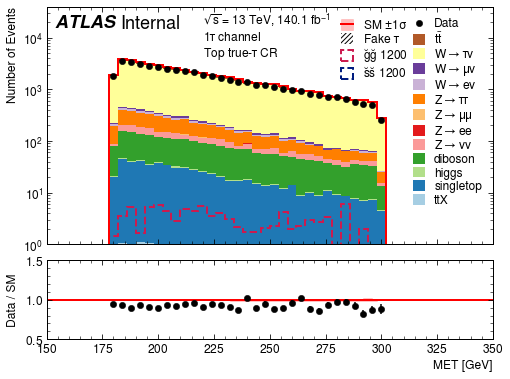

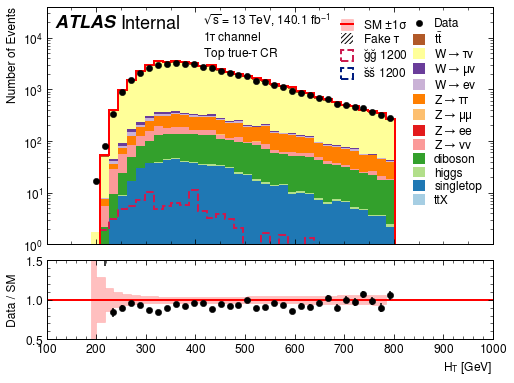

In [24]:
analysis_plotter(
    datas_dict,
    backgrounds_dict,
    truefaketaus_dict,
    gluinos_dict,
    squarks_dict,

    plot_features,

    True, 
    1,    
    'logarithmic',
)

In [ ]:
'''
file = ur.open("/disk/atlas3/data_MC/22.2.110/DeepSet/MC20a/vector_XEplateau/singletop.root")["NOMINAL"]
ar = file.arrays(library="ak")
ar['bjet_pt'] = ar.jet_pt[ar.jet_isBjet == 1]
ar['bjet_eta'] = ar.jet_eta[ar.jet_isBjet == 1]
'''

In [41]:
gluinos_dict['1200_1125_1088_1050']['bjet_eta']

ValueError: key "bjet_eta" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.2/src/libawkward/util.cpp#L525)

In [28]:
gluinos_dict["Event"]

KeyError: 'Event'

# COMPARISON

In [12]:
data_type = 'data'

In [13]:
datas_dict_RNN = analysis_processor(
    data_type,
    channel,

    analysis_base,
    campaigns,

    datas,

    region,
    subject,
    selection
)

Loading data sets: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]

Applied: Preselection.
Applied: CR & True-Tau.


In [14]:
data_type = 'background'

In [15]:
backgrounds_dict_RNN, truefaketaus_dict_RNN = analysis_processor(
    data_type,
    channel,

    analysis_base,
    campaigns,

    backgrounds,

    region,
    subject,
    selection
)

Loading data sets:   9%|▉         | 1/11 [00:12<02:01, 12.10s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  18%|█▊        | 2/11 [00:16<01:10,  7.81s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  27%|██▋       | 3/11 [00:23<00:56,  7.11s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  36%|███▋      | 4/11 [00:23<00:32,  4.62s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  45%|████▌     | 5/11 [00:27<00:25,  4.24s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  55%|█████▍    | 6/11 [00:29<00:16,  3.35s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  64%|██████▎   | 7/11 [00:29<00:09,  2.37s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  73%|███████▎  | 8/11 [00:30<00:05,  1.84s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  82%|████████▏ | 9/11 [00:34<00:05,  2.58s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  91%|█████████ | 10/11 [00:36<00:02,  2.40s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets: 100%|██████████| 11/11 [00:37<00:00,  3.39s/it]

Applied: Preselection.
Applied: CR & True-Tau.


In [19]:
data_type = 'data'

In [20]:
datas_dict_DeepSet = analysis_processor(
    data_type,
    channel,

    analysis_base,
    campaigns,

    datas,

    region,
    subject,
    selection
)

Loading data sets: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]

Applied: Preselection.
Applied: CR & True-Tau.


In [21]:
data_type = 'background'

In [22]:
backgrounds_dict_DeepSet, truefaketaus_dict_DeepSet = analysis_processor(
    data_type,
    channel,

    analysis_base,
    campaigns,

    backgrounds,

    region,
    subject,
    selection
)

Loading data sets:   9%|▉         | 1/11 [00:10<01:42, 10.24s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  18%|█▊        | 2/11 [00:13<00:57,  6.37s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  27%|██▋       | 3/11 [00:20<00:50,  6.25s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  36%|███▋      | 4/11 [00:20<00:27,  3.97s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  45%|████▌     | 5/11 [00:23<00:22,  3.72s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  55%|█████▍    | 6/11 [00:25<00:14,  2.98s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  64%|██████▎   | 7/11 [00:25<00:08,  2.12s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  73%|███████▎  | 8/11 [00:26<00:05,  1.67s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  82%|████████▏ | 9/11 [00:30<00:04,  2.34s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets:  91%|█████████ | 10/11 [00:32<00:02,  2.22s/it]

Applied: Preselection.
Applied: CR & True-Tau.


Loading data sets: 100%|██████████| 11/11 [00:32<00:00,  2.99s/it]

Applied: Preselection.
Applied: CR & True-Tau.


In [23]:
datas_dict_RNN['data']

<Array [{nVtx: 23, PVz: -40.9, ... weight: 1}] type='26635 * {"nVtx": int32, "PV...'>

In [24]:
datas_dict_DeepSet['data']

<Array [{nVtx: 20, PVz: -7, ... weight: 1}] type='21150 * {"nVtx": int32, "PVz":...'>

In [25]:
backgrounds_dict_RNN['ttbar']

<Array [{nVtx: 36, ... weight: 0.0749}] type='9337 * {"nVtx": int32, "PVz": floa...'>

In [26]:
backgrounds_dict_DeepSet['ttbar']

<Array [{nVtx: 20, PVz: -3.21, ... weight: 0}] type='6682 * {"nVtx": int32, "PVz...'>

In [27]:
gluinos_dict=None
squarks_dict=None

In [28]:
def MC_comparison(
    datas_dict,
    backgrounds_dict,
    # truefaketaus_dict,
    gluinos_dict,
    squarks_dict,

    plot_features,

    include_signal,         # True (include) | False (exclude)
    include_data,           # 1 (include) | 0 (exclude)
    scale_type,             # 'linear' | 'logarithmic'
):
    """ 
        Analysis plotting function. Parameters: datas_dict, backgrounds_dict, truefaketaus_dict, gluinos_dict, squarks_dict, plot_features, include_signal, include_data, scale_type.
    """

    color = sns.color_palette("Paired", n_colors = len(backgrounds_dict.keys()))

    if include_signal:   
        color_gluinos = sns.color_palette("rocket", n_colors = len(gluinos_dict.keys()))
        color_squarks = sns.color_palette("dark", n_colors = len(squarks_dict.keys()))

    scale_factor = 1

    with PdfPages(f'../Plots/X_UpROOT_Tau_{analysis_base}_Comparison_MC.pdf') as pdf:

        for i in range(0, len(plot_features)):

            fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 6))

            bins = np.linspace(plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end'], plot_features[i]['bins']+1)

            ax[0].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])
            ax[1].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])

            if ("n" in plot_features[i]) and ("divide" in plot_features[i]):
                datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                # datas_array = datas_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]

                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in truefaketaus_dict][::-1]]
                # if include_signal:     
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in squarks_dict][::-1]]
            elif "n" in plot_features[i]:
                datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]
                # datas_array = datas_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]

                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in truefaketaus_dict][::-1]]
                # if include_signal:  
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in squarks_dict][::-1]]
            elif "divide" in plot_features[i]:
                datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']]/[plot_features[i]['divide']]
                # datas_array = datas_dict['data'][plot_features[i]['name']]/[plot_features[i]['divide']]

                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]/[plot_features[i]['divide']]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] if len(truefaketaus_dict[x]) !=0 else truefaketaus_dict[x][plot_features[i]['name']] for x in truefaketaus_dict][::-1]]
                # if include_signal:  
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in squarks_dict][::-1]]
            else:
                datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']]
                # datas_array = datas_dict['data'][plot_features[i]['name']]

                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']] for x in truefaketaus_dict][::-1]]
                # if include_signal:  
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']] for x in squarks_dict][::-1]]

            # ---Signals---
            if include_signal:  
                # ---Gluinos---
                ax[0].hist(
                    gluinos_array,
                    weights = [x for x in [gluinos_dict[x].weight for x in gluinos_dict][::-1]],
                    bins = bins,
                    histtype = 'step',
                    label = gluinos[::-1],
                    color = color_gluinos,
                    linestyle = "dashed",
                    linewidth = 2,
                )
                # ---Gluinos---

                # ---Squarks---
                ax[0].hist(
                    squarks_array,
                    weights = [x for x in [squarks_dict[x].weight for x in squarks_dict][::-1]],
                    bins = bins,
                    histtype = 'step',
                    label = squarks[::-1],
                    color = color_squarks,
                    linestyle = "dashed",
                    linewidth = 2,
                )
                # ---Squarks---
            # ---Signals---

            # ---Datas (invisible)---
            n_datas, bins_datas, patches_datas = ax[0].hist(
                datas_array,
                weights = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0).weight * scale_factor,
                bins = bins,
                alpha=0,
            )
            # ---Datas (invisible)---

            # ---Merged Backgrounds (red)---
            n_backgrounds_merged, bins_backgrounds_merged, patches_backgrounds_merged = ax[0].hist(
                backgrounds_merged_array,
                weights = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0).weight * scale_factor,
                bins = bins,
                histtype = 'step',
                stacked = True,
                color = 'red',
                linewidth = 2
            )
            # ---Merged Backgrounds (red)---

            # ---Backgrounds---
            # ax[0].hist(
            #     backgrounds_array,
            #     weights = [x for x in [backgrounds_dict[x].weight*scale_factor for x in backgrounds_dict][::-1]],
            #     bins = bins,
            #     histtype = 'bar',
            #     stacked = True,
            #     label = labels_background[::-1],
            #     color = color
            # )
            # ---Backgrounds---

            # ---True & Fake Taus---
            # n_truefaketaus, bins_truefaketaus, patches_truefaketaus = ax[0].hist(
            #     truefaketaus_array,
            #     weights = [x for x in [truefaketaus_dict[x].weight*scale_factor for x in truefaketaus_dict][::-1]],
            #     bins = bins,
            #     histtype = 'bar',
            #     stacked = True,
            # )

            # plt.setp(
            #     [
            #         patches_truefaketaus[1], 
            #         patches_truefaketaus[3], 
            #         patches_truefaketaus[5], 
            #         patches_truefaketaus[7], 
            #         patches_truefaketaus[9], 
            #         patches_truefaketaus[11], 
            #         patches_truefaketaus[13], 
            #         patches_truefaketaus[15], 
            #         patches_truefaketaus[17],
            #         patches_truefaketaus[19],
            #         patches_truefaketaus[21],
            #         patches_truefaketaus[23]

            #     ],
            #     alpha = 0
            # )

            # plt.setp(
            #     [
            #         patches_truefaketaus[0], 
            #         patches_truefaketaus[2], 
            #         patches_truefaketaus[4], 
            #         patches_truefaketaus[6], 
            #         patches_truefaketaus[8], 
            #         patches_truefaketaus[10], 
            #         patches_truefaketaus[12], 
            #         patches_truefaketaus[14], 
            #         patches_truefaketaus[16],
            #         patches_truefaketaus[18],
            #         patches_truefaketaus[20]
            #     ], 
            #     facecolor = 'none',
            #     edgecolor = 'black',
            #     fill = False,
            #     hatch = '/////',
            #     alpha = 1,
            #     linewidth = 0.0
            # )

            # legend_truefaketaus = mpatches.Patch(
            #     facecolor = 'none', 
            #     edgecolor = 'black', 
            #     fill = False,
            #     hatch = '/////',
            #     alpha = 1,
            #     linewidth = 0.0
            # )
            # ---True & Fake Taus---

            # ---Tweak (0 to None)---
            n_by_zero = n_datas/n_datas
            n_datas = n_datas*n_by_zero
            # ---Tweak (0 to None)---

            # ---Standard Deviation Uncertainty (Not Working?)---
            std_unweighted = scipy.stats.binned_statistic(backgrounds_merged_array, backgrounds_merged_array, statistic='std', bins=bins)[0]
            sqrtn_unweighted = np.sqrt(np.histogram(backgrounds_merged_array, bins=bins)[0])
            sigma = std_unweighted / sqrtn_unweighted
            # ---Standard Deviation Uncertainty (Not Working?)---

            # ---Bins Center---
            bins_center = bins[:-1] + 0.5*(bins[1:] - bins[:-1])
            # ---Bins Center---

            # ---ATLAS Data---
            ax[0].scatter(
                bins_center, 
                n_datas, 
                marker='o', 
                c='black', 
                s=40, 
                alpha=include_data, 
                label="MC DeepSet", 
                zorder=2
            )
            # ---ATLAS Data---

            # ---ATLAS/MC Data---
            line = ax[1].axhline(
                y=1, 
                color='red', 
                linewidth = 2
            )
            ax[1].scatter(
                bins_center, 
                n_datas/n_backgrounds_merged, 
                marker='o', 
                c='black', 
                s=40, 
                alpha=1, 
                zorder=2
            )
            # ---ATLAS/MC Data---

            # ---Errors---
            ax[1].errorbar(
                # bins[:-1] + 0.5*(bins[1:] - bins[:-1]), 
                bins_center,
                n_datas/n_backgrounds_merged, 
                yerr=np.sqrt(n_datas)/n_datas, 
                fmt='.', 
                c='black'
            )
            # fill = ax[1].fill_between(
            #     bins[:-1],
            #     1 - sigma, 
            #     1 + sigma, 
            #     step='mid', 
            #     alpha=0.25,
            #     color='red'
            # )
            # ---Errors---

            # ---Axes Ranges---
            ymin, ymax = ax[0].get_ylim()

            if scale_type=='linear':
                ax[0].set_ylim([ymin, ymax * 1.3])
            elif scale_type=='logarithmic':
                ax[0].set_ylim([1, ymax*10])
            else:
                raise Exception("Unsupported scale type.")

            ax[1].set_ylim([0.5, 1.5])
            ax[0].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])
            # ---Axes Ranges---

            # ---Axes Labels & Spacing & Format---
            ax[0].set_ylabel(
                plot_features[i]['yaxis_label'], 
                loc="top", 
                fontsize=12
            )
            ax[1].set_ylabel(
                "RNN / DeepSet", 
                fontsize=12
            )
            ax[1].set_xlabel(
                plot_features[i]['xaxis_label'], 
                loc="right", 
                fontsize=12
            )
            # ax[1].set_xlabel(r"{}".format(plot_features[i]['xaxis_label']), loc="right")

            fig.align_ylabels([ax[0], ax[1]])

            ax[0].locator_params(nbins=10, axis='y')
            ax[1].locator_params(nbins=10, axis='x')

            ax[0].tick_params(axis='y', labelsize=12)
            ax[1].tick_params(axis='x', labelsize=12)
            ax[1].tick_params(axis='y', labelsize=12)

            # ax[0].tick_params('y', length=20, width=1, which='major')
            # ax[0].tick_params('y', length=10, width=1, which='minor')

            ax[0].set_xticklabels([])


            if scale_type=='linear':
                ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 7))         
            elif scale_type=='logarithmic':
                ax[0].set_yscale('log')
            else:
                raise Exception("Unsupported scale type.")

            # ---Axes Labels & Spacing & Format---

            # ---Spacing Between Plots---
            plt.subplots_adjust(hspace = 0.1)
            # ---Spacing Between Plots---

            # ---Legend---
            handles, labels = ax[0].get_legend_handles_labels()
            if include_signal:
                first_legend = ax[0].legend(
                    [
                        # (line, fill), 
                        # legend_truefaketaus, 
                        # handles[0],
                        # handles[1],
                        #handles[2],
                        #handles[3],
                        # handles[4],
                        # handles[5],
                    ], 
                    [
                        # r"SM $\pm 1 \sigma$",
                        # r"Fake $\tau$",
                        # r"$\breve g \breve g$ " + f"{labels[0][0:4]}",
                        #r"$\breve g \breve g$ " + f"{labels[1][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[0][0:4]}",
                        #r"$\breve s \breve s$ " + f"{labels[1][0:4]}",
                        # r"$\breve g \breve g$ " + f"{labels[2][0:3]}",
                        # r"$\breve s \breve s$ " + f"{labels[3][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[4][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[5][0:3]}"
                    ], 
                    loc=(0.70, 0.67),       # 2 - (0.65, 0.67), # 6 - (0.65, 0.38)
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                second_legend = ax[0].legend(
                    handles[:-14:-1], 
                    labels[:-14:-1], 
                    loc="upper right", 
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                ax[0].add_artist(first_legend)
            else:
                first_legend = ax[0].legend(
                    [
                        line,
                        # legend_truefaketaus
                    ], 
                    [
                        "MC RNN", 
                        # r"Fake $\tau$"
                    ], 
                        loc=(0.76, 0.80), 
                        prop={'size': 12}, 
                        labelspacing = 0.1, 
                        handlelength=1, 
                        handleheight=1
                    )
                second_legend = ax[0].legend(
                    handles[::-1], 
                    labels[::-1], 
                    loc="upper right", 
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                ax[0].add_artist(first_legend)
            # ---Legend---

            # ---ATLAS Label---
            ampl.draw_atlas_label(0.02, 4.1, status='int')
            # ---ATLAS Label---

            # ---Additional Info Label---
            ax[0].text(
            0.35, 
            0.79, 
            r"$\sqrt{s}=13$" + " TeV, 29.0 fb" + r"$^{-1}$" "\n"
            f"{channel}"+ r"$\tau$" + " channel"  "\n"
            # "Preselection",
            f"W true-" + r"$\tau$" + " CR",
            fontsize=12,
            transform=ax[0].transAxes
            )
            # ---Additional Info Label---
            
            # ---Tight Layout---
            pdf.savefig(bbox_inches='tight')
            # ---Tight Layout---

            # ---Just One Plot in JupyterNotebook---
            if i == 0:
               plt.show()
            else:
               plt.close()
            # ---Just One Plot in JupyterNotebook---

In [29]:
MC_comparison(
    backgrounds_dict_DeepSet,
    backgrounds_dict_RNN,
    # truefaketaus_dict_RNN,
    gluinos_dict,
    squarks_dict,

    plot_features,

    False, 
    1,    
    'logarithmic',
)

In [32]:
def data_comparison(
    datas_dict,
    backgrounds_dict,
    # truefaketaus_dict,
    gluinos_dict,
    squarks_dict,

    plot_features,

    include_signal,         # True (include) | False (exclude)
    include_data,           # 1 (include) | 0 (exclude)
    scale_type,             # 'linear' | 'logarithmic'
):
    """ 
        Analysis plotting function. Parameters: datas_dict, backgrounds_dict, truefaketaus_dict, gluinos_dict, squarks_dict, plot_features, include_signal, include_data, scale_type.
    """

    color = sns.color_palette("Paired", n_colors = len(backgrounds_dict.keys()))

    if include_signal:   
        color_gluinos = sns.color_palette("rocket", n_colors = len(gluinos_dict.keys()))
        color_squarks = sns.color_palette("dark", n_colors = len(squarks_dict.keys()))

    scale_factor = 1

    with PdfPages(f'../Plots/X_UpROOT_Tau_{analysis_base}_Comparison_Data.pdf') as pdf:

        for i in range(0, len(plot_features)):

            fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 6))

            bins = np.linspace(plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end'], plot_features[i]['bins']+1)

            ax[0].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])
            ax[1].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])

            if ("n" in plot_features[i]) and ("divide" in plot_features[i]):
                # datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                
                datas_array = datas_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                backgrounds_merged_array = backgrounds_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]

                # backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in truefaketaus_dict][::-1]]
                # if include_signal:     
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in squarks_dict][::-1]]
            elif "n" in plot_features[i]:
                # datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]
                
                datas_array = datas_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]
                backgrounds_merged_array = backgrounds_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]

                # backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in truefaketaus_dict][::-1]]
                # if include_signal:  
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in squarks_dict][::-1]]
            elif "divide" in plot_features[i]:
                # datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']]/[plot_features[i]['divide']]
                
                datas_array = datas_dict['data'][plot_features[i]['name']]/[plot_features[i]['divide']]
                backgrounds_merged_array = backgrounds_dict['data'][plot_features[i]['name']]/[plot_features[i]['divide']]

                # backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]/[plot_features[i]['divide']]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] if len(truefaketaus_dict[x]) !=0 else truefaketaus_dict[x][plot_features[i]['name']] for x in truefaketaus_dict][::-1]]
                # if include_signal:  
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in squarks_dict][::-1]]
            else:
                # datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']]
                
                datas_array = datas_dict['data'][plot_features[i]['name']]
                backgrounds_merged_array = backgrounds_dict['data'][plot_features[i]['name']]

                # backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']] for x in truefaketaus_dict][::-1]]
                # if include_signal:  
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']] for x in squarks_dict][::-1]]

            # ---Signals---
            if include_signal:  
                # ---Gluinos---
                ax[0].hist(
                    gluinos_array,
                    weights = [x for x in [gluinos_dict[x].weight for x in gluinos_dict][::-1]],
                    bins = bins,
                    histtype = 'step',
                    label = gluinos[::-1],
                    color = color_gluinos,
                    linestyle = "dashed",
                    linewidth = 2,
                )
                # ---Gluinos---

                # ---Squarks---
                ax[0].hist(
                    squarks_array,
                    weights = [x for x in [squarks_dict[x].weight for x in squarks_dict][::-1]],
                    bins = bins,
                    histtype = 'step',
                    label = squarks[::-1],
                    color = color_squarks,
                    linestyle = "dashed",
                    linewidth = 2,
                )
                # ---Squarks---
            # ---Signals---

            # ---Datas (invisible)---
            n_datas, bins_datas, patches_datas = ax[0].hist(
                datas_array,
                weights = datas_dict['data'].weight,
                bins = bins,
                alpha=0,
            )
            # ---Datas (invisible)---

            # ---Merged Backgrounds (red)---
            n_backgrounds_merged, bins_backgrounds_merged, patches_backgrounds_merged = ax[0].hist(
                backgrounds_merged_array,
                weights = backgrounds_dict['data'].weight,
                bins = bins,
                histtype = 'step',
                stacked = True,
                color = 'red',
                linewidth = 2
            )
            # ---Merged Backgrounds (red)---

            # ---Backgrounds---
            # ax[0].hist(
            #     backgrounds_array,
            #     weights = [x for x in [backgrounds_dict[x].weight*scale_factor for x in backgrounds_dict][::-1]],
            #     bins = bins,
            #     histtype = 'bar',
            #     stacked = True,
            #     label = labels_background[::-1],
            #     color = color
            # )
            # ---Backgrounds---

            # ---True & Fake Taus---
            # n_truefaketaus, bins_truefaketaus, patches_truefaketaus = ax[0].hist(
            #     truefaketaus_array,
            #     weights = [x for x in [truefaketaus_dict[x].weight*scale_factor for x in truefaketaus_dict][::-1]],
            #     bins = bins,
            #     histtype = 'bar',
            #     stacked = True,
            # )

            # plt.setp(
            #     [
            #         patches_truefaketaus[1], 
            #         patches_truefaketaus[3], 
            #         patches_truefaketaus[5], 
            #         patches_truefaketaus[7], 
            #         patches_truefaketaus[9], 
            #         patches_truefaketaus[11], 
            #         patches_truefaketaus[13], 
            #         patches_truefaketaus[15], 
            #         patches_truefaketaus[17],
            #         patches_truefaketaus[19],
            #         patches_truefaketaus[21],
            #         patches_truefaketaus[23]

            #     ],
            #     alpha = 0
            # )

            # plt.setp(
            #     [
            #         patches_truefaketaus[0], 
            #         patches_truefaketaus[2], 
            #         patches_truefaketaus[4], 
            #         patches_truefaketaus[6], 
            #         patches_truefaketaus[8], 
            #         patches_truefaketaus[10], 
            #         patches_truefaketaus[12], 
            #         patches_truefaketaus[14], 
            #         patches_truefaketaus[16],
            #         patches_truefaketaus[18],
            #         patches_truefaketaus[20]
            #     ], 
            #     facecolor = 'none',
            #     edgecolor = 'black',
            #     fill = False,
            #     hatch = '/////',
            #     alpha = 1,
            #     linewidth = 0.0
            # )

            # legend_truefaketaus = mpatches.Patch(
            #     facecolor = 'none', 
            #     edgecolor = 'black', 
            #     fill = False,
            #     hatch = '/////',
            #     alpha = 1,
            #     linewidth = 0.0
            # )
            # ---True & Fake Taus---

            # ---Tweak (0 to None)---
            n_by_zero = n_datas/n_datas
            n_datas = n_datas*n_by_zero
            # ---Tweak (0 to None)---

            # ---Standard Deviation Uncertainty (Not Working?)---
            std_unweighted = scipy.stats.binned_statistic(backgrounds_merged_array, backgrounds_merged_array, statistic='std', bins=bins)[0]
            sqrtn_unweighted = np.sqrt(np.histogram(backgrounds_merged_array, bins=bins)[0])
            sigma = std_unweighted / sqrtn_unweighted
            # ---Standard Deviation Uncertainty (Not Working?)---

            # ---Bins Center---
            bins_center = bins[:-1] + 0.5*(bins[1:] - bins[:-1])
            # ---Bins Center---

            # ---ATLAS Data---
            ax[0].scatter(
                bins_center, 
                n_datas, 
                marker='o', 
                c='black', 
                s=40, 
                alpha=include_data, 
                label="Data DeepSet", 
                zorder=2
            )
            # ---ATLAS Data---

            # ---ATLAS/MC Data---
            line = ax[1].axhline(
                y=1, 
                color='red', 
                linewidth = 2
            )
            ax[1].scatter(
                bins_center, 
                n_datas/n_backgrounds_merged, 
                marker='o', 
                c='black', 
                s=40, 
                alpha=1, 
                zorder=2
            )
            # ---ATLAS/MC Data---

            # ---Errors---
            ax[1].errorbar(
                # bins[:-1] + 0.5*(bins[1:] - bins[:-1]), 
                bins_center,
                n_datas/n_backgrounds_merged, 
                yerr=np.sqrt(n_datas)/n_datas, 
                fmt='.', 
                c='black'
            )
            # fill = ax[1].fill_between(
            #     bins[:-1],
            #     1 - sigma, 
            #     1 + sigma, 
            #     step='mid', 
            #     alpha=0.25,
            #     color='red'
            # )
            # ---Errors---

            # ---Axes Ranges---
            ymin, ymax = ax[0].get_ylim()

            if scale_type=='linear':
                ax[0].set_ylim([ymin, ymax * 1.3])
            elif scale_type=='logarithmic':
                ax[0].set_ylim([1, ymax*10])
            else:
                raise Exception("Unsupported scale type.")

            ax[1].set_ylim([0.5, 1.5])
            ax[0].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])
            # ---Axes Ranges---

            # ---Axes Labels & Spacing & Format---
            ax[0].set_ylabel(
                plot_features[i]['yaxis_label'], 
                loc="top", 
                fontsize=12
            )
            ax[1].set_ylabel(
                "RNN / DeepSet", 
                fontsize=12
            )
            ax[1].set_xlabel(
                plot_features[i]['xaxis_label'], 
                loc="right", 
                fontsize=12
            )
            # ax[1].set_xlabel(r"{}".format(plot_features[i]['xaxis_label']), loc="right")

            fig.align_ylabels([ax[0], ax[1]])

            ax[0].locator_params(nbins=10, axis='y')
            ax[1].locator_params(nbins=10, axis='x')

            ax[0].tick_params(axis='y', labelsize=12)
            ax[1].tick_params(axis='x', labelsize=12)
            ax[1].tick_params(axis='y', labelsize=12)

            # ax[0].tick_params('y', length=20, width=1, which='major')
            # ax[0].tick_params('y', length=10, width=1, which='minor')

            ax[0].set_xticklabels([])


            if scale_type=='linear':
                ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 7))         
            elif scale_type=='logarithmic':
                ax[0].set_yscale('log')
            else:
                raise Exception("Unsupported scale type.")

            # ---Axes Labels & Spacing & Format---

            # ---Spacing Between Plots---
            plt.subplots_adjust(hspace = 0.1)
            # ---Spacing Between Plots---

            # ---Legend---
            handles, labels = ax[0].get_legend_handles_labels()
            if include_signal:
                first_legend = ax[0].legend(
                    [
                        # (line, fill), 
                        # legend_truefaketaus, 
                        # handles[0],
                        # handles[1],
                        #handles[2],
                        #handles[3],
                        # handles[4],
                        # handles[5],
                    ], 
                    [
                        # r"SM $\pm 1 \sigma$",
                        # r"Fake $\tau$",
                        # r"$\breve g \breve g$ " + f"{labels[0][0:4]}",
                        #r"$\breve g \breve g$ " + f"{labels[1][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[0][0:4]}",
                        #r"$\breve s \breve s$ " + f"{labels[1][0:4]}",
                        # r"$\breve g \breve g$ " + f"{labels[2][0:3]}",
                        # r"$\breve s \breve s$ " + f"{labels[3][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[4][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[5][0:3]}"
                    ], 
                    loc=(0.70, 0.67),       # 2 - (0.65, 0.67), # 6 - (0.65, 0.38)
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                second_legend = ax[0].legend(
                    handles[:-14:-1], 
                    labels[:-14:-1], 
                    loc="upper right", 
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                ax[0].add_artist(first_legend)
            else:
                first_legend = ax[0].legend(
                    [
                        line,
                        # legend_truefaketaus
                    ], 
                    [
                        "Data RNN", 
                        # r"Fake $\tau$"
                    ], 
                        loc=(0.75, 0.80), 
                        prop={'size': 12}, 
                        labelspacing = 0.1, 
                        handlelength=1, 
                        handleheight=1
                    )
                second_legend = ax[0].legend(
                    handles[::-1], 
                    labels[::-1], 
                    loc="upper right", 
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                ax[0].add_artist(first_legend)
            # ---Legend---

            # ---ATLAS Label---
            ampl.draw_atlas_label(0.02, 4.1, status='int')
            # ---ATLAS Label---

            # ---Additional Info Label---
            ax[0].text(
            0.35, 
            0.79, 
            r"$\sqrt{s}=13$" + " TeV, 29.0 fb" + r"$^{-1}$" "\n"
            f"{channel}"+ r"$\tau$" + " channel"  "\n"
            # "Preselection",
            f"W true-" + r"$\tau$" + " CR",
            fontsize=12,
            transform=ax[0].transAxes
            )
            # ---Additional Info Label---
            
            # ---Tight Layout---
            pdf.savefig(bbox_inches='tight')
            # ---Tight Layout---

            # ---Just One Plot in JupyterNotebook---
            if i == 0:
               plt.show()
            else:
               plt.close()
            # ---Just One Plot in JupyterNotebook---

In [33]:
data_comparison(
    datas_dict_DeepSet,
    datas_dict_RNN,
    # truefaketaus_dict_RNN,
    gluinos_dict,
    squarks_dict,

    plot_features,

    False, 
    1,    
    'logarithmic',
)

In [21]:
truefaketaus_dict_RNN

{'ttbar-true': <Array [{nVtx: 13, ... weight: 0.159}] type='21159 * {"nVtx": int32, "PVz": floa...'>,
 'ttbar-fake': <Array [{nVtx: 15, ... weight: 0.717}] type='929 * {"nVtx": int32, "PVz": float3...'>,
 'wtaunu-true': <Array [{nVtx: 28, ... weight: 0.304}] type='154643 * {"nVtx": int32, "PVz": flo...'>,
 'wtaunu-fake': <Array [{nVtx: 19, ... weight: 0.153}] type='3120 * {"nVtx": int32, "PVz": float...'>,
 'wmunu-true': <Array [{nVtx: 22, ... weight: 0.034}] type='9 * {"nVtx": int32, "PVz": float32,...'>,
 'wmunu-fake': <Array [{nVtx: 18, ... weight: 0.101}] type='4801 * {"nVtx": int32, "PVz": float...'>,
 'wenu-true': <Array [{nVtx: 21, ... weight: -0.489}] type='8 * {"nVtx": int32, "PVz": float32...'>,
 'wenu-fake': <Array [{nVtx: 18, ... weight: 0.0362}] type='3884 * {"nVtx": int32, "PVz": floa...'>,
 'ztautau-true': <Array [{nVtx: 23, ... weight: -0.152}] type='139421 * {"nVtx": int32, "PVz": fl...'>,
 'ztautau-fake': <Array [{nVtx: 22, ... weight: -0.0247}] type='2538 * {"nVtx": 

In [22]:
truefaketaus_dict_DeepSet

{'ttbar-true': <Array [{nVtx: 18, ... weight: 0.00591}] type='14628 * {"nVtx": int32, "PVz": fl...'>,
 'ttbar-fake': <Array [{nVtx: 20, ... weight: 0.14}] type='449 * {"nVtx": int32, "PVz": float32...'>,
 'wtaunu-true': <Array [{nVtx: 22, ... weight: 0.31}] type='114375 * {"nVtx": int32, "PVz": floa...'>,
 'wtaunu-fake': <Array [{nVtx: 14, ... weight: 0.183}] type='1459 * {"nVtx": int32, "PVz": float...'>,
 'wmunu-true': <Array [{nVtx: 32, ... weight: 0.0414}] type='5 * {"nVtx": int32, "PVz": float32...'>,
 'wmunu-fake': <Array [{nVtx: 18, ... weight: 0.172}] type='3637 * {"nVtx": int32, "PVz": float...'>,
 'wenu-true': <Array [{nVtx: 21, ... weight: 0.0932}] type='5 * {"nVtx": int32, "PVz": float32...'>,
 'wenu-fake': <Array [{nVtx: 18, ... weight: 0.231}] type='1249 * {"nVtx": int32, "PVz": float...'>,
 'ztautau-true': <Array [{nVtx: 33, ... weight: 0.0587}] type='111599 * {"nVtx": int32, "PVz": fl...'>,
 'ztautau-fake': <Array [{nVtx: 23, ... weight: 0.34}] type='1947 * {"nVtx": int

In [61]:
keys_true = [
    'ttbar-true',
 'wtaunu-true',
 'wmunu-true',
 'wenu-true',
 'ztautau-true',
 'zmumu-true',
 'zee-true',
 'znunu-true',
 'diboson-true',
 'higgs-true',
 'singletop-true',
 'ttX-true'
]

In [63]:
keys_fake = [
'ttbar-fake',
 'wtaunu-fake',
 'wmunu-fake',
 'wenu-fake',
 'ztautau-fake',
 'zmumu-fake',
 'zee-fake',
 'znunu-fake',
 'diboson-fake',
 'higgs-fake',
 'singletop-fake',
 'ttX-fake'
]

In [60]:
[x for i, x in enumerate(truefaketaus_dict_DeepSet) if i%2==0]

['ttbar-true',
 'wtaunu-true',
 'wmunu-true',
 'wenu-true',
 'ztautau-true',
 'zmumu-true',
 'zee-true',
 'znunu-true',
 'diboson-true',
 'higgs-true',
 'singletop-true',
 'ttX-true']

In [64]:
[truefaketaus_dict_DeepSet[x] for i, x in enumerate(truefaketaus_dict_DeepSet) if i%2!=0]

[<Array [{nVtx: 20, ... weight: 0.14}] type='449 * {"nVtx": int32, "PVz": float32...'>,
 <Array [{nVtx: 14, ... weight: 0.183}] type='1459 * {"nVtx": int32, "PVz": float...'>,
 <Array [{nVtx: 18, ... weight: 0.172}] type='3637 * {"nVtx": int32, "PVz": float...'>,
 <Array [{nVtx: 18, ... weight: 0.231}] type='1249 * {"nVtx": int32, "PVz": float...'>,
 <Array [{nVtx: 23, ... weight: 0.34}] type='1947 * {"nVtx": int32, "PVz": float3...'>,
 <Array [{nVtx: 17, ... weight: -0.151}] type='512 * {"nVtx": int32, "PVz": float...'>,
 <Array [{nVtx: 23, ... weight: 0.00115}] type='8 * {"nVtx": int32, "PVz": float3...'>,
 <Array [{nVtx: 17, ... weight: 0.231}] type='2973 * {"nVtx": int32, "PVz": float...'>,
 <Array [{nVtx: 17, ... weight: 0.0811}] type='974 * {"nVtx": int32, "PVz": float...'>,
 <Array [{nVtx: 31, ... weight: 0.00755}] type='104 * {"nVtx": int32, "PVz": floa...'>,
 <Array [{nVtx: 11, ... weight: -0.023}] type='159 * {"nVtx": int32, "PVz": float...'>,
 <Array [{nVtx: 19, ... weight: 

In [32]:
ak.concatenate([truefaketaus_dict_RNN[x] for i, x in enumerate(truefaketaus_dict_RNN) if i%2==0])

<Array [{nVtx: 13, ... weight: 0.000221}] type='391236 * {"nVtx": int32, "PVz": ...'>

In [33]:
ak.concatenate([truefaketaus_dict_RNN[x] for i, x in enumerate(truefaketaus_dict_RNN) if i%2!=0])

<Array [{nVtx: 15, ... weight: 0.000355}] type='25296 * {"nVtx": int32, "PVz": f...'>

In [34]:
ak.concatenate([truefaketaus_dict_DeepSet[x] for i, x in enumerate(truefaketaus_dict_DeepSet) if i%2==0])

<Array [{nVtx: 18, ... weight: 0.000468}] type='299089 * {"nVtx": int32, "PVz": ...'>

In [35]:
ak.concatenate([truefaketaus_dict_DeepSet[x] for i, x in enumerate(truefaketaus_dict_DeepSet) if i%2!=0])

<Array [{nVtx: 20, ... weight: 0.00035}] type='13561 * {"nVtx": int32, "PVz": fl...'>

In [ ]:
keys = [
    
]

In [92]:
truth_dict_RNN = {x:truefaketaus_dict_RNN[x] for x in keys_true}
truth_dict_RNN

{'ttbar-true': <Array [{nVtx: 13, ... weight: 0.159}] type='21159 * {"nVtx": int32, "PVz": floa...'>,
 'wtaunu-true': <Array [{nVtx: 28, ... weight: 0.304}] type='154643 * {"nVtx": int32, "PVz": flo...'>,
 'wmunu-true': <Array [{nVtx: 22, ... weight: 0.034}] type='9 * {"nVtx": int32, "PVz": float32,...'>,
 'wenu-true': <Array [{nVtx: 21, ... weight: -0.489}] type='8 * {"nVtx": int32, "PVz": float32...'>,
 'ztautau-true': <Array [{nVtx: 23, ... weight: -0.152}] type='139421 * {"nVtx": int32, "PVz": fl...'>,
 'zmumu-true': <Array [{nVtx: 29, ... weight: 0.00587}] type='2 * {"nVtx": int32, "PVz": float3...'>,
 'zee-true': <Array [] type='0 * {"nVtx": int32, "PVz": float32, "eventClean": int8, "isBadTi...'>,
 'znunu-true': <Array [{nVtx: 30, ... weight: 0.0363}] type='16 * {"nVtx": int32, "PVz": float3...'>,
 'diboson-true': <Array [{nVtx: 27, ... weight: 0.0743}] type='60266 * {"nVtx": int32, "PVz": flo...'>,
 'higgs-true': <Array [{nVtx: 11, ... weight: 0.002}] type='4951 * {"nVtx": int3

In [93]:
fake_dict_RNN = {x:truefaketaus_dict_RNN[x] for x in keys_fake}
fake_dict_RNN

{'ttbar-fake': <Array [{nVtx: 15, ... weight: 0.717}] type='929 * {"nVtx": int32, "PVz": float3...'>,
 'wtaunu-fake': <Array [{nVtx: 19, ... weight: 0.153}] type='3120 * {"nVtx": int32, "PVz": float...'>,
 'wmunu-fake': <Array [{nVtx: 18, ... weight: 0.101}] type='4801 * {"nVtx": int32, "PVz": float...'>,
 'wenu-fake': <Array [{nVtx: 18, ... weight: 0.0362}] type='3884 * {"nVtx": int32, "PVz": floa...'>,
 'ztautau-fake': <Array [{nVtx: 22, ... weight: -0.0247}] type='2538 * {"nVtx": int32, "PVz": flo...'>,
 'zmumu-fake': <Array [{nVtx: 24, ... weight: -0.0198}] type='594 * {"nVtx": int32, "PVz": floa...'>,
 'zee-fake': <Array [{nVtx: 27, ... weight: 0.00429}] type='19 * {"nVtx": int32, "PVz": float...'>,
 'znunu-fake': <Array [{nVtx: 23, ... weight: 0.347}] type='6841 * {"nVtx": int32, "PVz": float...'>,
 'diboson-fake': <Array [{nVtx: 17, ... weight: 0.129}] type='1857 * {"nVtx": int32, "PVz": float...'>,
 'higgs-fake': <Array [{nVtx: 19, ... weight: 0.00376}] type='144 * {"nVtx": int

In [94]:
truth_dict_DeepSet = {x:truefaketaus_dict_DeepSet[x] for x in keys_true}
truth_dict_DeepSet

{'ttbar-true': <Array [{nVtx: 18, ... weight: 0.00591}] type='14628 * {"nVtx": int32, "PVz": fl...'>,
 'wtaunu-true': <Array [{nVtx: 22, ... weight: 0.31}] type='114375 * {"nVtx": int32, "PVz": floa...'>,
 'wmunu-true': <Array [{nVtx: 32, ... weight: 0.0414}] type='5 * {"nVtx": int32, "PVz": float32...'>,
 'wenu-true': <Array [{nVtx: 21, ... weight: 0.0932}] type='5 * {"nVtx": int32, "PVz": float32...'>,
 'ztautau-true': <Array [{nVtx: 33, ... weight: 0.0587}] type='111599 * {"nVtx": int32, "PVz": fl...'>,
 'zmumu-true': <Array [] type='0 * {"nVtx": int32, "PVz": float32, "eventClean": int8, "isBadTi...'>,
 'zee-true': <Array [] type='0 * {"nVtx": int32, "PVz": float32, "eventClean": int8, "isBadTi...'>,
 'znunu-true': <Array [{nVtx: 31, ... weight: 0.0705}] type='8 * {"nVtx": int32, "PVz": float32...'>,
 'diboson-true': <Array [{nVtx: 21, ... weight: 0.0625}] type='46624 * {"nVtx": int32, "PVz": flo...'>,
 'higgs-true': <Array [{nVtx: 11, ... weight: 0.00199}] type='4177 * {"nVtx": in

In [95]:
fake_dict_DeepSet = {x:truefaketaus_dict_DeepSet[x] for x in keys_fake}
fake_dict_DeepSet

{'ttbar-fake': <Array [{nVtx: 20, ... weight: 0.14}] type='449 * {"nVtx": int32, "PVz": float32...'>,
 'wtaunu-fake': <Array [{nVtx: 14, ... weight: 0.183}] type='1459 * {"nVtx": int32, "PVz": float...'>,
 'wmunu-fake': <Array [{nVtx: 18, ... weight: 0.172}] type='3637 * {"nVtx": int32, "PVz": float...'>,
 'wenu-fake': <Array [{nVtx: 18, ... weight: 0.231}] type='1249 * {"nVtx": int32, "PVz": float...'>,
 'ztautau-fake': <Array [{nVtx: 23, ... weight: 0.34}] type='1947 * {"nVtx": int32, "PVz": float3...'>,
 'zmumu-fake': <Array [{nVtx: 17, ... weight: -0.151}] type='512 * {"nVtx": int32, "PVz": float...'>,
 'zee-fake': <Array [{nVtx: 23, ... weight: 0.00115}] type='8 * {"nVtx": int32, "PVz": float3...'>,
 'znunu-fake': <Array [{nVtx: 17, ... weight: 0.231}] type='2973 * {"nVtx": int32, "PVz": float...'>,
 'diboson-fake': <Array [{nVtx: 17, ... weight: 0.0811}] type='974 * {"nVtx": int32, "PVz": float...'>,
 'higgs-fake': <Array [{nVtx: 31, ... weight: 0.00755}] type='104 * {"nVtx": int

In [113]:
def truth(
    datas_dict,
    backgrounds_dict,
    # truefaketaus_dict,
    gluinos_dict,
    squarks_dict,

    plot_features,

    include_signal,         # True (include) | False (exclude)
    include_data,           # 1 (include) | 0 (exclude)
    scale_type,             # 'linear' | 'logarithmic'
):
    """ 
        Analysis plotting function. Parameters: datas_dict, backgrounds_dict, truefaketaus_dict, gluinos_dict, squarks_dict, plot_features, include_signal, include_data, scale_type.
    """

    color = sns.color_palette("Paired", n_colors = len(backgrounds_dict.keys()))

    if include_signal:   
        color_gluinos = sns.color_palette("rocket", n_colors = len(gluinos_dict.keys()))
        color_squarks = sns.color_palette("dark", n_colors = len(squarks_dict.keys()))

    scale_factor = 1

    with PdfPages(f'../Plots/X_UpROOT_Tau_{analysis_base}_Comparison_MC.pdf') as pdf:

        for i in range(0, len(plot_features)):

            fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 6))

            bins = np.linspace(plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end'], plot_features[i]['bins']+1)

            ax[0].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])
            ax[1].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])

            if ("n" in plot_features[i]) and ("divide" in plot_features[i]):

                datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]



                # datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                # datas_array = datas_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]

                # backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in truefaketaus_dict][::-1]]
                # if include_signal:     
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1]/[plot_features[i]['divide']] for x in squarks_dict][::-1]]
            elif "n" in plot_features[i]:
                datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]
                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]


                # datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]
                # datas_array = datas_dict['data'][plot_features[i]['name']][:, plot_features[i]['n']-1]

                # backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']][:, plot_features[i]['n']-1]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in truefaketaus_dict][::-1]]
                # if include_signal:  
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']][:, plot_features[i]['n']-1] for x in squarks_dict][::-1]]
            elif "divide" in plot_features[i]:
                datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']]/[plot_features[i]['divide']]
                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]/[plot_features[i]['divide']]



                # datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']]/[plot_features[i]['divide']]
                # datas_array = datas_dict['data'][plot_features[i]['name']]/[plot_features[i]['divide']]

                # backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]/[plot_features[i]['divide']]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] if len(truefaketaus_dict[x]) !=0 else truefaketaus_dict[x][plot_features[i]['name']] for x in truefaketaus_dict][::-1]]
                # if include_signal:  
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']]/[plot_features[i]['divide']] for x in squarks_dict][::-1]]
            else:
                datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']]
                backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]

                # datas_array = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0)[plot_features[i]['name']]
                # datas_array = datas_dict['data'][plot_features[i]['name']]

                # backgrounds_merged_array = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0)[plot_features[i]['name']]
                # backgrounds_array = [x for x in [backgrounds_dict[x][plot_features[i]['name']] for x in backgrounds_dict][::-1]]
                # truefaketaus_array = [x for x in [truefaketaus_dict[x][plot_features[i]['name']] for x in truefaketaus_dict][::-1]]
                # if include_signal:  
                #     gluinos_array = [x for x in [gluinos_dict[x][plot_features[i]['name']] for x in gluinos_dict][::-1]]
                #     squarks_array = [x for x in [squarks_dict[x][plot_features[i]['name']] for x in squarks_dict][::-1]]

            # ---Signals---
            if include_signal:  
                # ---Gluinos---
                ax[0].hist(
                    gluinos_array,
                    weights = [x for x in [gluinos_dict[x].weight for x in gluinos_dict][::-1]],
                    bins = bins,
                    histtype = 'step',
                    label = gluinos[::-1],
                    color = color_gluinos,
                    linestyle = "dashed",
                    linewidth = 2,
                )
                # ---Gluinos---

                # ---Squarks---
                ax[0].hist(
                    squarks_array,
                    weights = [x for x in [squarks_dict[x].weight for x in squarks_dict][::-1]],
                    bins = bins,
                    histtype = 'step',
                    label = squarks[::-1],
                    color = color_squarks,
                    linestyle = "dashed",
                    linewidth = 2,
                )
                # ---Squarks---
            # ---Signals---

            # ---Datas (invisible)---
            n_datas, bins_datas, patches_datas = ax[0].hist(
                datas_array,
                weights = ak.concatenate([datas_dict[x] for x in datas_dict], axis=0).weight * scale_factor,
                bins = bins,
                alpha=0,
            )
            # ---Datas (invisible)---

            # ---Merged Backgrounds (red)---
            n_backgrounds_merged, bins_backgrounds_merged, patches_backgrounds_merged = ax[0].hist(
                backgrounds_merged_array,
                weights = ak.concatenate([backgrounds_dict[x] for x in backgrounds_dict], axis=0).weight * scale_factor,
                bins = bins,
                histtype = 'step',
                stacked = True,
                color = 'red',
                linewidth = 2
            )
            # ---Merged Backgrounds (red)---

            # ---Backgrounds---
            # ax[0].hist(
            #     backgrounds_array,
            #     weights = [x for x in [backgrounds_dict[x].weight*scale_factor for x in backgrounds_dict][::-1]],
            #     bins = bins,
            #     histtype = 'bar',
            #     stacked = True,
            #     label = labels_background[::-1],
            #     color = color
            # )
            # ---Backgrounds---

            # ---True & Fake Taus---
            # n_truefaketaus, bins_truefaketaus, patches_truefaketaus = ax[0].hist(
            #     truefaketaus_array,
            #     weights = [x for x in [truefaketaus_dict[x].weight*scale_factor for x in truefaketaus_dict][::-1]],
            #     bins = bins,
            #     histtype = 'bar',
            #     stacked = True,
            # )

            # plt.setp(
            #     [
            #         patches_truefaketaus[1], 
            #         patches_truefaketaus[3], 
            #         patches_truefaketaus[5], 
            #         patches_truefaketaus[7], 
            #         patches_truefaketaus[9], 
            #         patches_truefaketaus[11], 
            #         patches_truefaketaus[13], 
            #         patches_truefaketaus[15], 
            #         patches_truefaketaus[17],
            #         patches_truefaketaus[19],
            #         patches_truefaketaus[21],
            #         patches_truefaketaus[23]

            #     ],
            #     alpha = 0
            # )

            # plt.setp(
            #     [
            #         patches_truefaketaus[0], 
            #         patches_truefaketaus[2], 
            #         patches_truefaketaus[4], 
            #         patches_truefaketaus[6], 
            #         patches_truefaketaus[8], 
            #         patches_truefaketaus[10], 
            #         patches_truefaketaus[12], 
            #         patches_truefaketaus[14], 
            #         patches_truefaketaus[16],
            #         patches_truefaketaus[18],
            #         patches_truefaketaus[20]
            #     ], 
            #     facecolor = 'none',
            #     edgecolor = 'black',
            #     fill = False,
            #     hatch = '/////',
            #     alpha = 1,
            #     linewidth = 0.0
            # )

            # legend_truefaketaus = mpatches.Patch(
            #     facecolor = 'none', 
            #     edgecolor = 'black', 
            #     fill = False,
            #     hatch = '/////',
            #     alpha = 1,
            #     linewidth = 0.0
            # )
            # ---True & Fake Taus---

            # ---Tweak (0 to None)---
            n_by_zero = n_datas/n_datas
            n_datas = n_datas*n_by_zero
            # ---Tweak (0 to None)---

            # ---Standard Deviation Uncertainty (Not Working?)---
            std_unweighted = scipy.stats.binned_statistic(backgrounds_merged_array, backgrounds_merged_array, statistic='std', bins=bins)[0]
            sqrtn_unweighted = np.sqrt(np.histogram(backgrounds_merged_array, bins=bins)[0])
            sigma = std_unweighted / sqrtn_unweighted
            # ---Standard Deviation Uncertainty (Not Working?)---

            # ---Bins Center---
            bins_center = bins[:-1] + 0.5*(bins[1:] - bins[:-1])
            # ---Bins Center---

            # ---ATLAS Data---
            ax[0].scatter(
                bins_center, 
                n_datas, 
                marker='o', 
                c='black', 
                s=40, 
                alpha=include_data, 
                label="MC DeepSet", 
                zorder=2
            )
            # ---ATLAS Data---

            # ---ATLAS/MC Data---
            line = ax[1].axhline(
                y=1, 
                color='red', 
                linewidth = 2
            )
            ax[1].scatter(
                bins_center, 
                n_datas/n_backgrounds_merged, 
                marker='o', 
                c='black', 
                s=40, 
                alpha=1, 
                zorder=2
            )
            # ---ATLAS/MC Data---

            # ---Errors---
            ax[1].errorbar(
                # bins[:-1] + 0.5*(bins[1:] - bins[:-1]), 
                bins_center,
                n_datas/n_backgrounds_merged, 
                yerr=np.sqrt(n_datas)/n_datas, 
                fmt='.', 
                c='black'
            )
            # fill = ax[1].fill_between(
            #     bins[:-1],
            #     1 - sigma, 
            #     1 + sigma, 
            #     step='mid', 
            #     alpha=0.25,
            #     color='red'
            # )
            # ---Errors---

            # ---Axes Ranges---
            ymin, ymax = ax[0].get_ylim()

            if scale_type=='linear':
                ax[0].set_ylim([ymin, ymax * 1.3])
            elif scale_type=='logarithmic':
                ax[0].set_ylim([1, ymax*10])
            else:
                raise Exception("Unsupported scale type.")

            ax[1].set_ylim([0.5, 1.5])
            ax[0].set_xlim([plot_features[i]['xaxis_start'], plot_features[i]['xaxis_end']])
            # ---Axes Ranges---

            # ---Axes Labels & Spacing & Format---
            ax[0].set_ylabel(
                plot_features[i]['yaxis_label'], 
                loc="top", 
                fontsize=12
            )
            ax[1].set_ylabel(
                "RNN / DeepSet", 
                fontsize=12
            )
            ax[1].set_xlabel(
                plot_features[i]['xaxis_label'], 
                loc="right", 
                fontsize=12
            )
            # ax[1].set_xlabel(r"{}".format(plot_features[i]['xaxis_label']), loc="right")

            fig.align_ylabels([ax[0], ax[1]])

            ax[0].locator_params(nbins=10, axis='y')
            ax[1].locator_params(nbins=10, axis='x')

            ax[0].tick_params(axis='y', labelsize=12)
            ax[1].tick_params(axis='x', labelsize=12)
            ax[1].tick_params(axis='y', labelsize=12)

            # ax[0].tick_params('y', length=20, width=1, which='major')
            # ax[0].tick_params('y', length=10, width=1, which='minor')

            ax[0].set_xticklabels([])


            if scale_type=='linear':
                ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 7))         
            elif scale_type=='logarithmic':
                ax[0].set_yscale('log')
            else:
                raise Exception("Unsupported scale type.")

            # ---Axes Labels & Spacing & Format---

            # ---Spacing Between Plots---
            plt.subplots_adjust(hspace = 0.1)
            # ---Spacing Between Plots---

            # ---Legend---
            handles, labels = ax[0].get_legend_handles_labels()
            if include_signal:
                first_legend = ax[0].legend(
                    [
                        # (line, fill), 
                        # legend_truefaketaus, 
                        # handles[0],
                        # handles[1],
                        #handles[2],
                        #handles[3],
                        # handles[4],
                        # handles[5],
                    ], 
                    [
                        # r"SM $\pm 1 \sigma$",
                        # r"Fake $\tau$",
                        # r"$\breve g \breve g$ " + f"{labels[0][0:4]}",
                        #r"$\breve g \breve g$ " + f"{labels[1][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[0][0:4]}",
                        #r"$\breve s \breve s$ " + f"{labels[1][0:4]}",
                        # r"$\breve g \breve g$ " + f"{labels[2][0:3]}",
                        # r"$\breve s \breve s$ " + f"{labels[3][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[4][0:4]}",
                        # r"$\breve s \breve s$ " + f"{labels[5][0:3]}"
                    ], 
                    loc=(0.70, 0.67),       # 2 - (0.65, 0.67), # 6 - (0.65, 0.38)
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                second_legend = ax[0].legend(
                    handles[:-14:-1], 
                    labels[:-14:-1], 
                    loc="upper right", 
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                ax[0].add_artist(first_legend)
            else:
                first_legend = ax[0].legend(
                    [
                        line,
                        # legend_truefaketaus
                    ], 
                    [
                        "MC RNN", 
                        # r"Fake $\tau$"
                    ], 
                        loc=(0.76, 0.80), 
                        prop={'size': 12}, 
                        labelspacing = 0.1, 
                        handlelength=1, 
                        handleheight=1
                    )
                second_legend = ax[0].legend(
                    handles[::-1], 
                    labels[::-1], 
                    loc="upper right", 
                    prop={'size': 12}, 
                    labelspacing = 0.1, 
                    handlelength=1, 
                    handleheight=1
                )
                ax[0].add_artist(first_legend)
            # ---Legend---

            # ---ATLAS Label---
            ampl.draw_atlas_label(0.02, 4.1, status='int')
            # ---ATLAS Label---

            # ---Additional Info Label---
            ax[0].text(
            0.35, 
            0.79, 
            r"$\sqrt{s}=13$" + " TeV, 140.1 fb" + r"$^{-1}$" "\n"
            f"{channel}"+ r"$\tau$" + " channel"  "\n"
            # "Preselection",
            f"W true-" + r"$\tau$" + " CR",
            fontsize=12,
            transform=ax[0].transAxes
            )
            # ---Additional Info Label---
            

            ax[0].set_title('Fake Taus (Run2)', fontsize=12)


            # ---Tight Layout---
            pdf.savefig(bbox_inches='tight')
            # ---Tight Layout---

            # ---Just One Plot in JupyterNotebook---
            if i == 0:
               plt.show()
            else:
               plt.close()
            # ---Just One Plot in JupyterNotebook---

In [111]:
gluinos_dict = None
squarks_dict = None

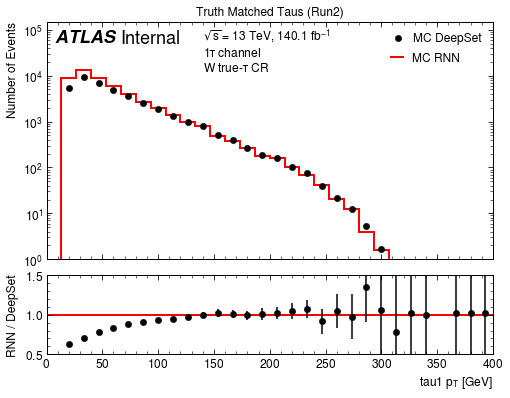

In [112]:
truth(
    truth_dict_DeepSet,
    truth_dict_RNN,
    # truefaketaus_dict_RNN,
    gluinos_dict,
    squarks_dict,

    plot_features,

    False, 
    1,    
    'logarithmic',
)

In [114]:
truth(
    fake_dict_DeepSet,
    fake_dict_RNN,
    # truefaketaus_dict_RNN,
    gluinos_dict,
    squarks_dict,

    plot_features,

    False, 
    1,    
    'logarithmic',
)